In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import copy

import arviz as az
import matplotlib.pyplot as plt
import neuromodels as nm
import numpy as np
import pandas as pd
import pylfi
import quantities as pq
import scipy.stats as stats
import seaborn as sns

from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import correlation_coefficient
from tqdm import tqdm_notebook as tqdm
from utils import *
from viziphant.rasterplot import rasterplot_rates
from viziphant.spike_train_correlation import plot_corrcoef

[INFO] [2021.10.24 4:17:22 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2021.10.24 4:17:22 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.2
 Built: Oct  8 2021 07:17:41

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
size = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": size,
    "font.size": size,
    "legend.fontsize": size,
    "xtick.labelsize": size-1,
    "ytick.labelsize": size-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
plt.rc('text', usetex=True)

# Set path to save the figures
FIGURE_PATH = "./../latex/figures" 
TABLE_PATH = "./../latex/tables" 

def fig_path(fig_id):
    """
    Input name of figure to load or save with extension as dtype str
    """
    return os.path.join(FIGURE_PATH + "/", fig_id)


def tab_path(tab_id):
    """
    Input name of table to load or save with extension as dtype str
    """
    return os.path.join(TABLE_PATH + "/", tab_id)


def df_to_latex(df, outfile):
    """
    Render dataframe to a LaTeX tabular environment table and write to file
    """
    n = len(df.columns)
    col_format = n * 'c'
    # Render dataframe to a LaTeX tabular environment table and write to file
    pd.options.display.float_format = '{:,.3f}'.format
    df = df.apply(lambda x: x.astype(
        int) if np.allclose(x, x.astype(int)) else x)
    pd.options.display.latex.escape = False
    latex = df.to_latex(index=False, column_format=col_format)
    latex = latex.replace('\\toprule', '\\hline \\hline')
    latex = latex.replace('\\midrule', '\\hline \\hline')
    latex = latex.replace('\\bottomrule', '\\hline \\hline')

    with open(tab_path(outfile), 'w') as f:
        f.write(latex)

# Set figure size
pt = 410 #360

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

fs = set_size(pt, fraction=1)
print(fs)

(5.673170056731701, 3.5062119190183605)


In [3]:
path = "data/"

# Brunel Network Model AI State Inference

## Observed data

In [4]:
# Experimental setup parameters 

order = 2500    # -> NE=10,000 ; NI=2500 ; N_tot=12,500 ; CE=1000 ; CI=250
epsilon = 0.1   # connection probability
D = 1.5         # synaptic delay (ms)
T = 1000        # simulation time (ms)
N_rec = 20      # record output from N_rec neurons
n_type = 'exc'  # record excitatory spike trains
J = 0.1         # excitatory synapse weight (mV)

# ground truth
eta_ai = 2.       # range [1.5, 4], use uniform prior
g_ai = 5.          # range [4, 8], use uniform prior

# In phase diagram:
# g = 4 corresponds to balance between excitation and inhibition
# eta = 1 corresponds to input sufficient to reach firing threshold

In [5]:
# load observed data
spiketrains = load_spiketrain('data/obs_ai_data.pkl')

# statistics calculator
s_stats = ["mean_firing_rate",  # rate estimation
           "mean_cv",           # spike interval statistic
           "fanofactor"         # statistic across spike trains
           ]

t_start = 100. * pq.ms
t_stop = T * pq.ms

sts = nm.statistics.SpikeTrainStats(stats=s_stats,
                                    t_start=t_start,
                                    t_stop=t_stop
                                    )

sum_stats = sts(spiketrains)

for s, r in zip(s_stats, sum_stats):
    print(f'{s}: {r}')

mean_firing_rate: 0.03661111111111111
mean_cv: 0.42506007658105566
fanofactor: 0.23413793103448277


### Raster and rate plot

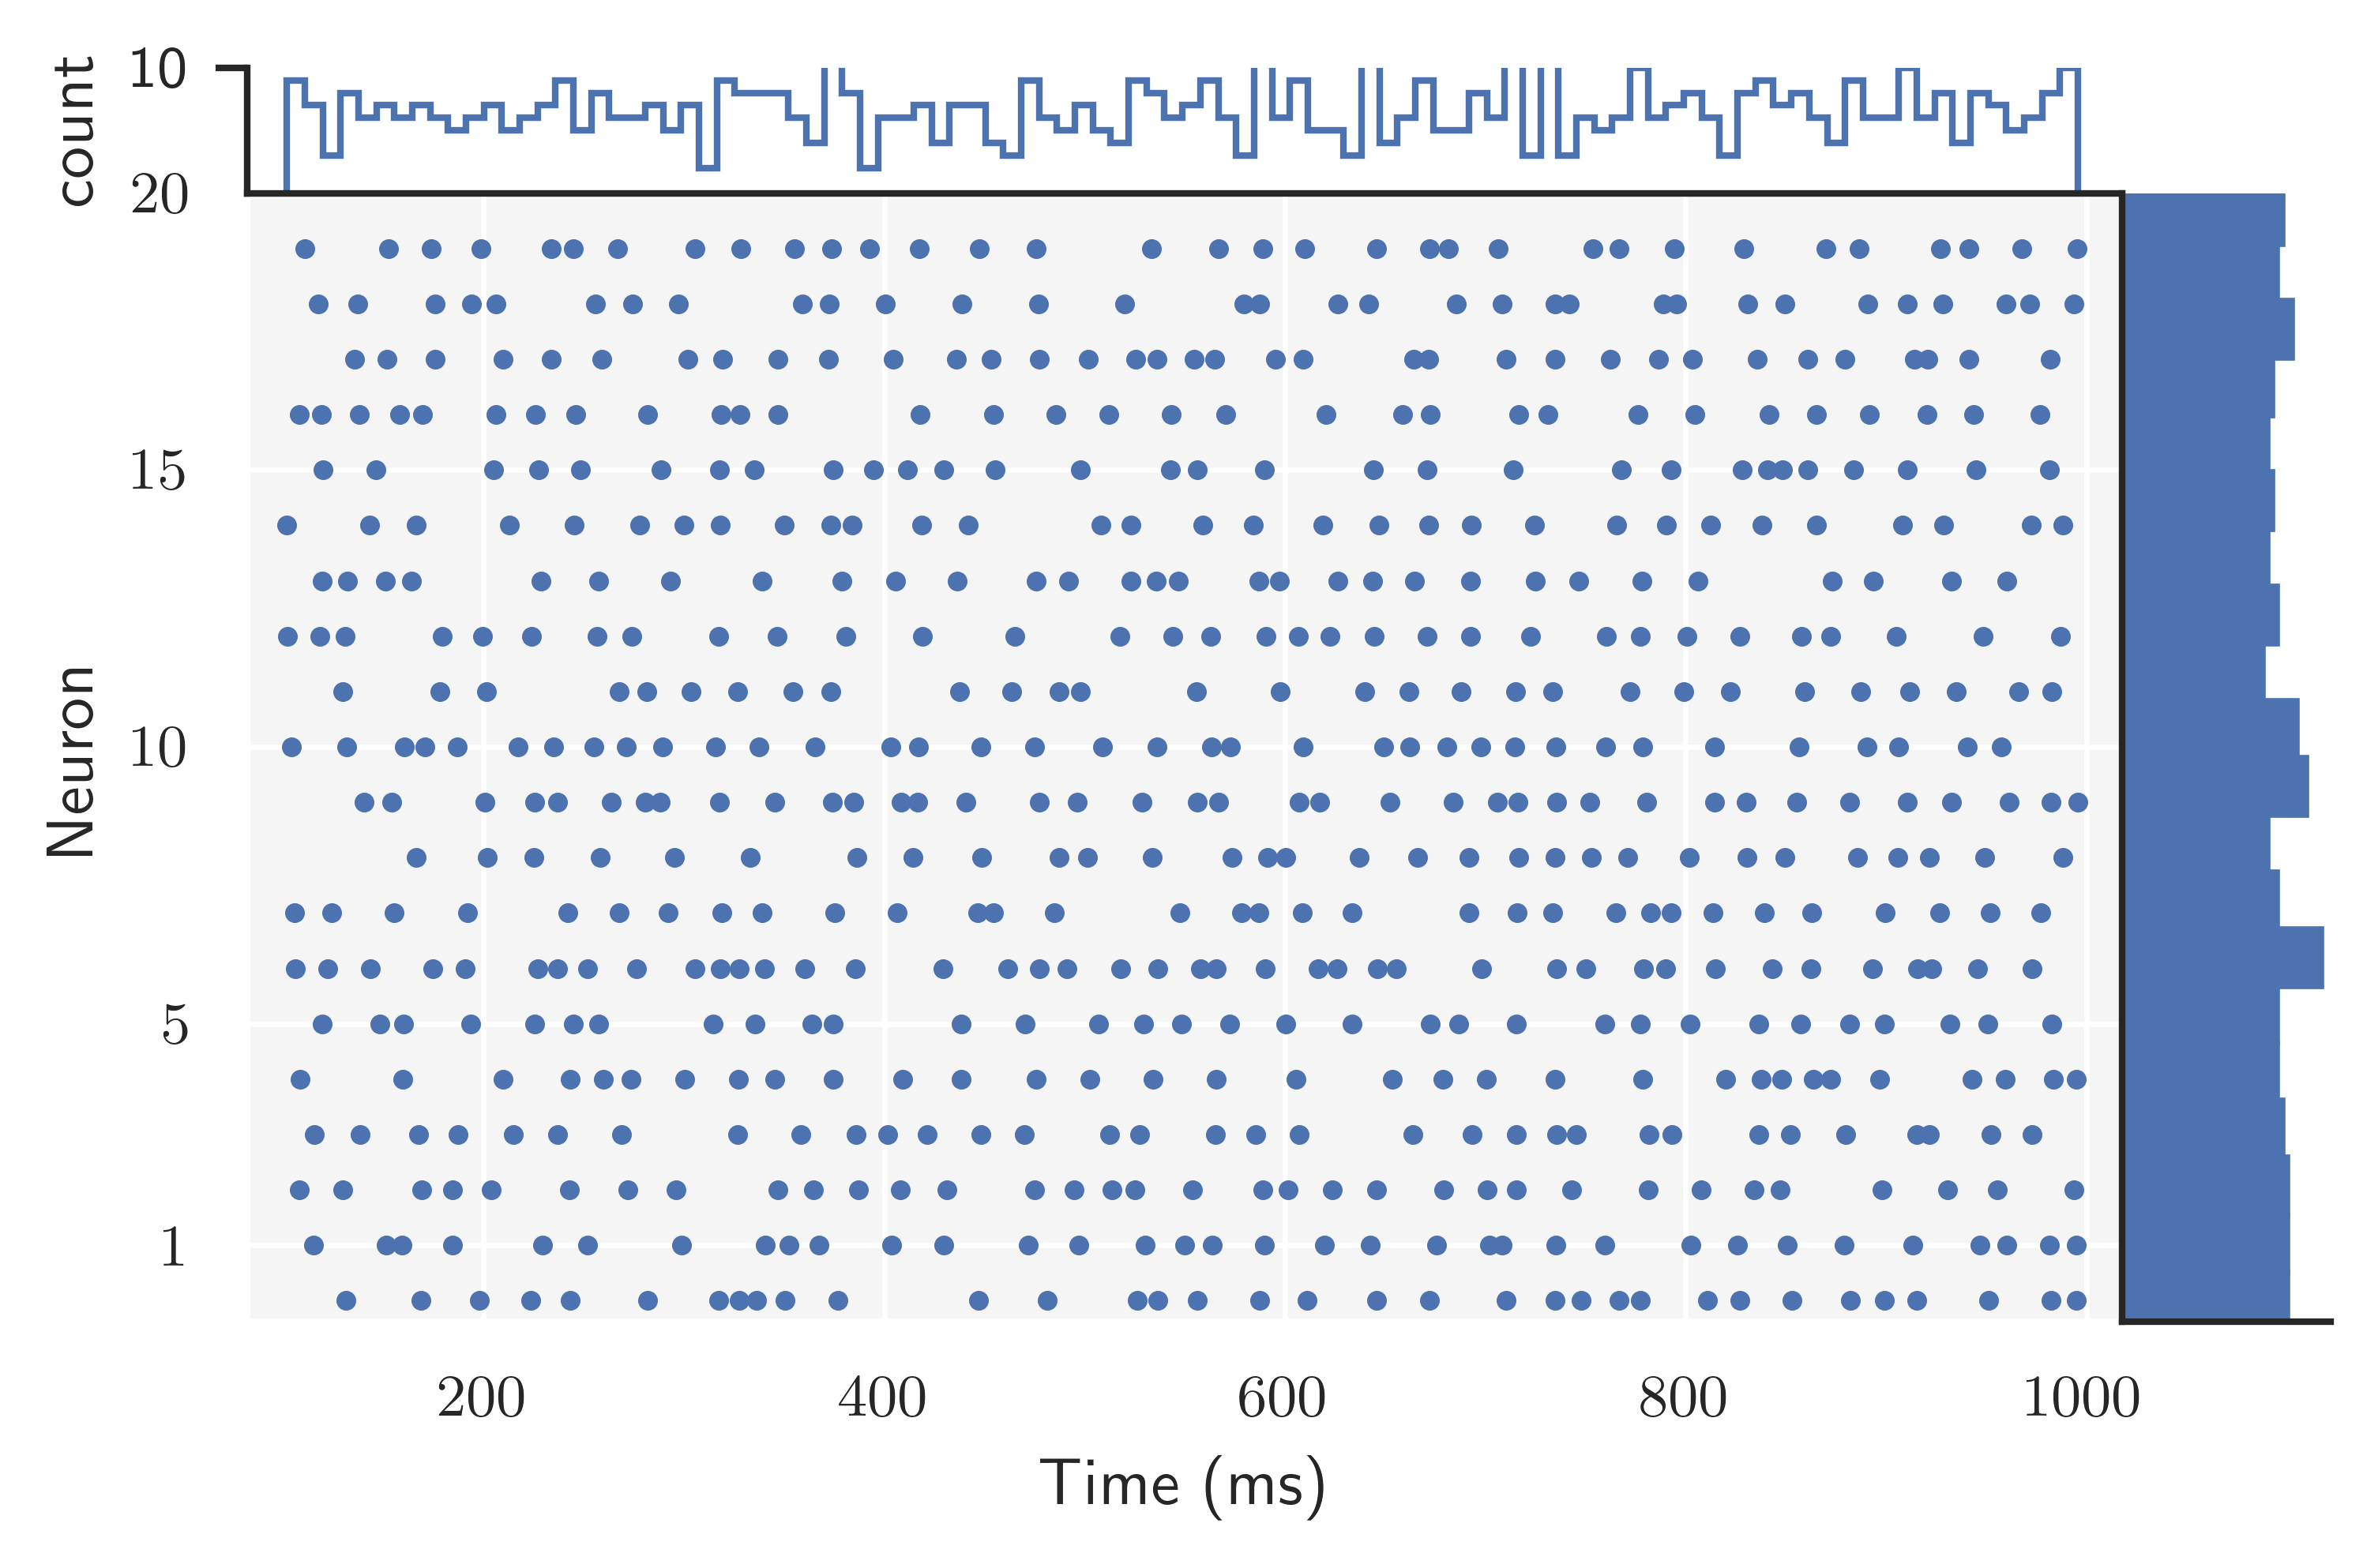

In [6]:
t_start = 100. * pq.ms
t_stop = T * pq.ms

spiketrains_slice = slice_spiketrains(spiketrains,
                                      t_start=t_start,
                                      t_stop=t_stop
                                      )

fig, ax = plt.subplots(figsize=fs,
                       constrained_layout=True,
                       dpi=300
                       )


rasterplot_rates(spiketrains_slice, ax=ax)
ax.set(yticks=[1, 5, 10, 15, 20],
       ylabel='Neuron'
       )

fig.savefig(fig_path('brunel_obs_ai.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Correlation matrix

seismic
PiYG
bwr

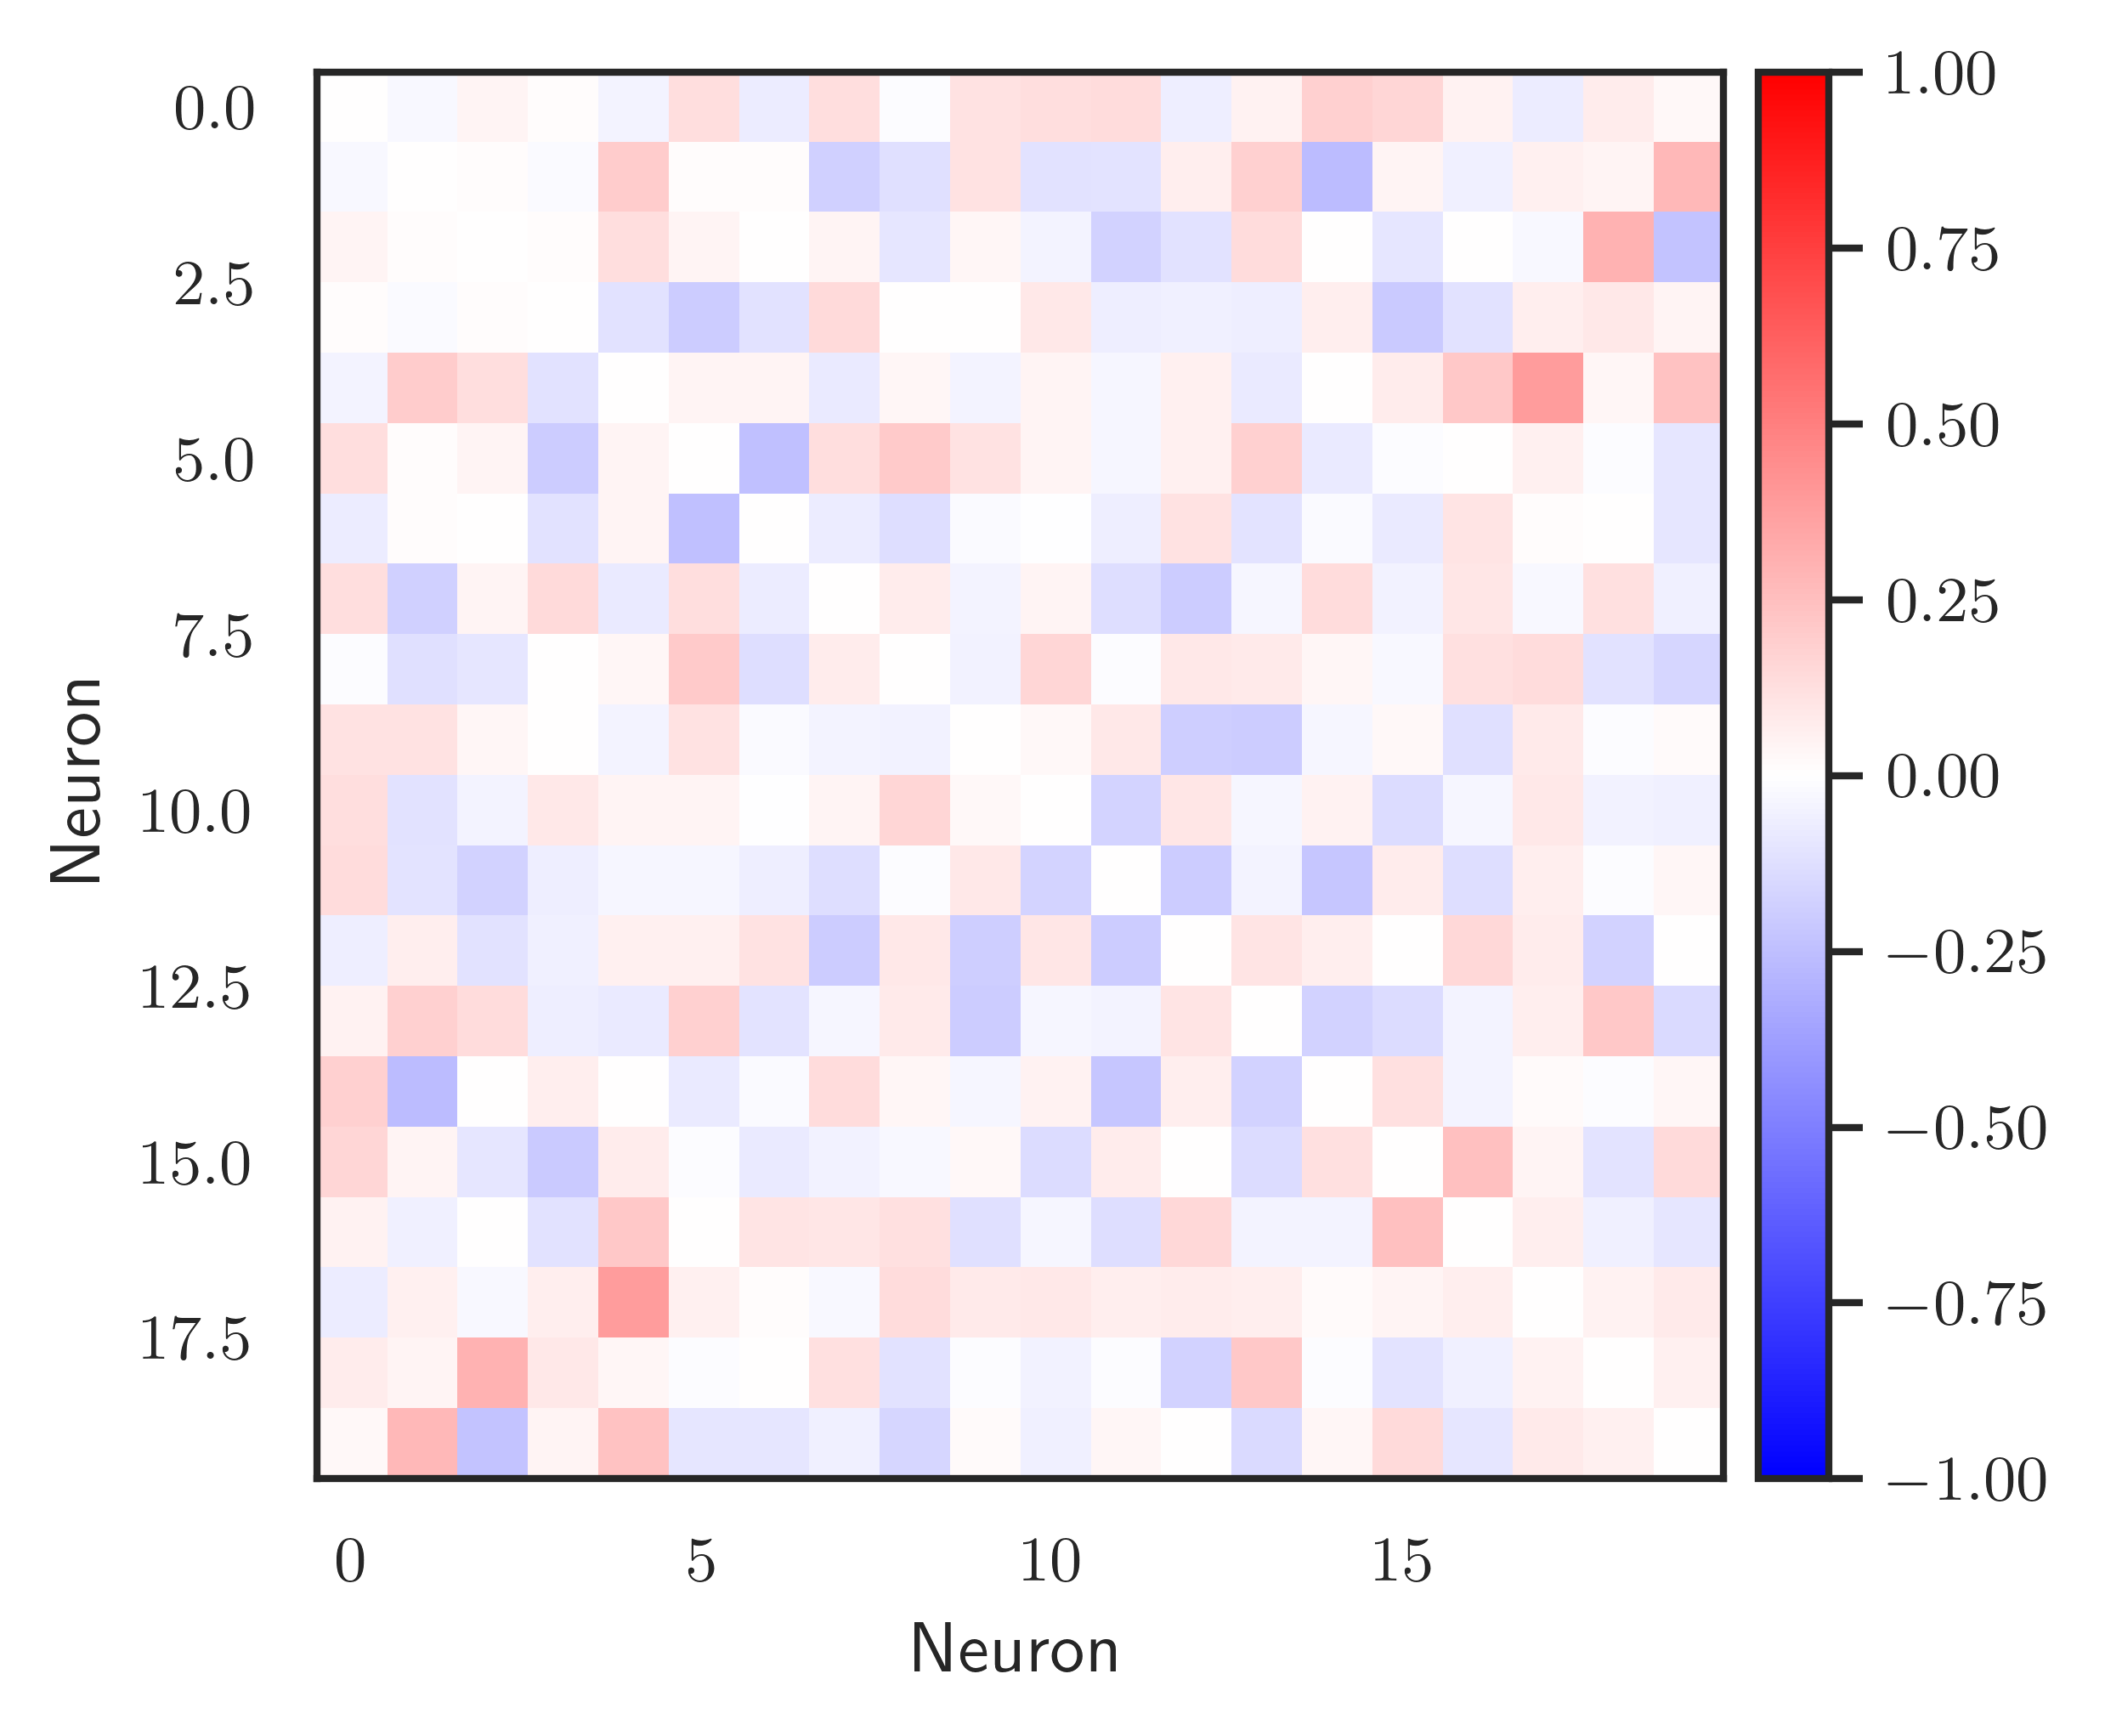

In [7]:
binned_spiketrains = BinnedSpikeTrain(spiketrains, bin_size=10 * pq.ms)
corrcoef_matrix = correlation_coefficient(binned_spiketrains)

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

    plot_corrcoef(corrcoef_matrix, colormap='bwr', correlation_range='full', axes=ax)

    ax.set(xlabel='Neuron',
           ylabel='Neuron',
           #title='Correlation coefficient matrix'
           )

    fig.savefig(fig_path('brunel_obs_corr.pdf'), 
                format='pdf', 
                dpi=300, 
                bbox_inches='tight'
               )

## Priors

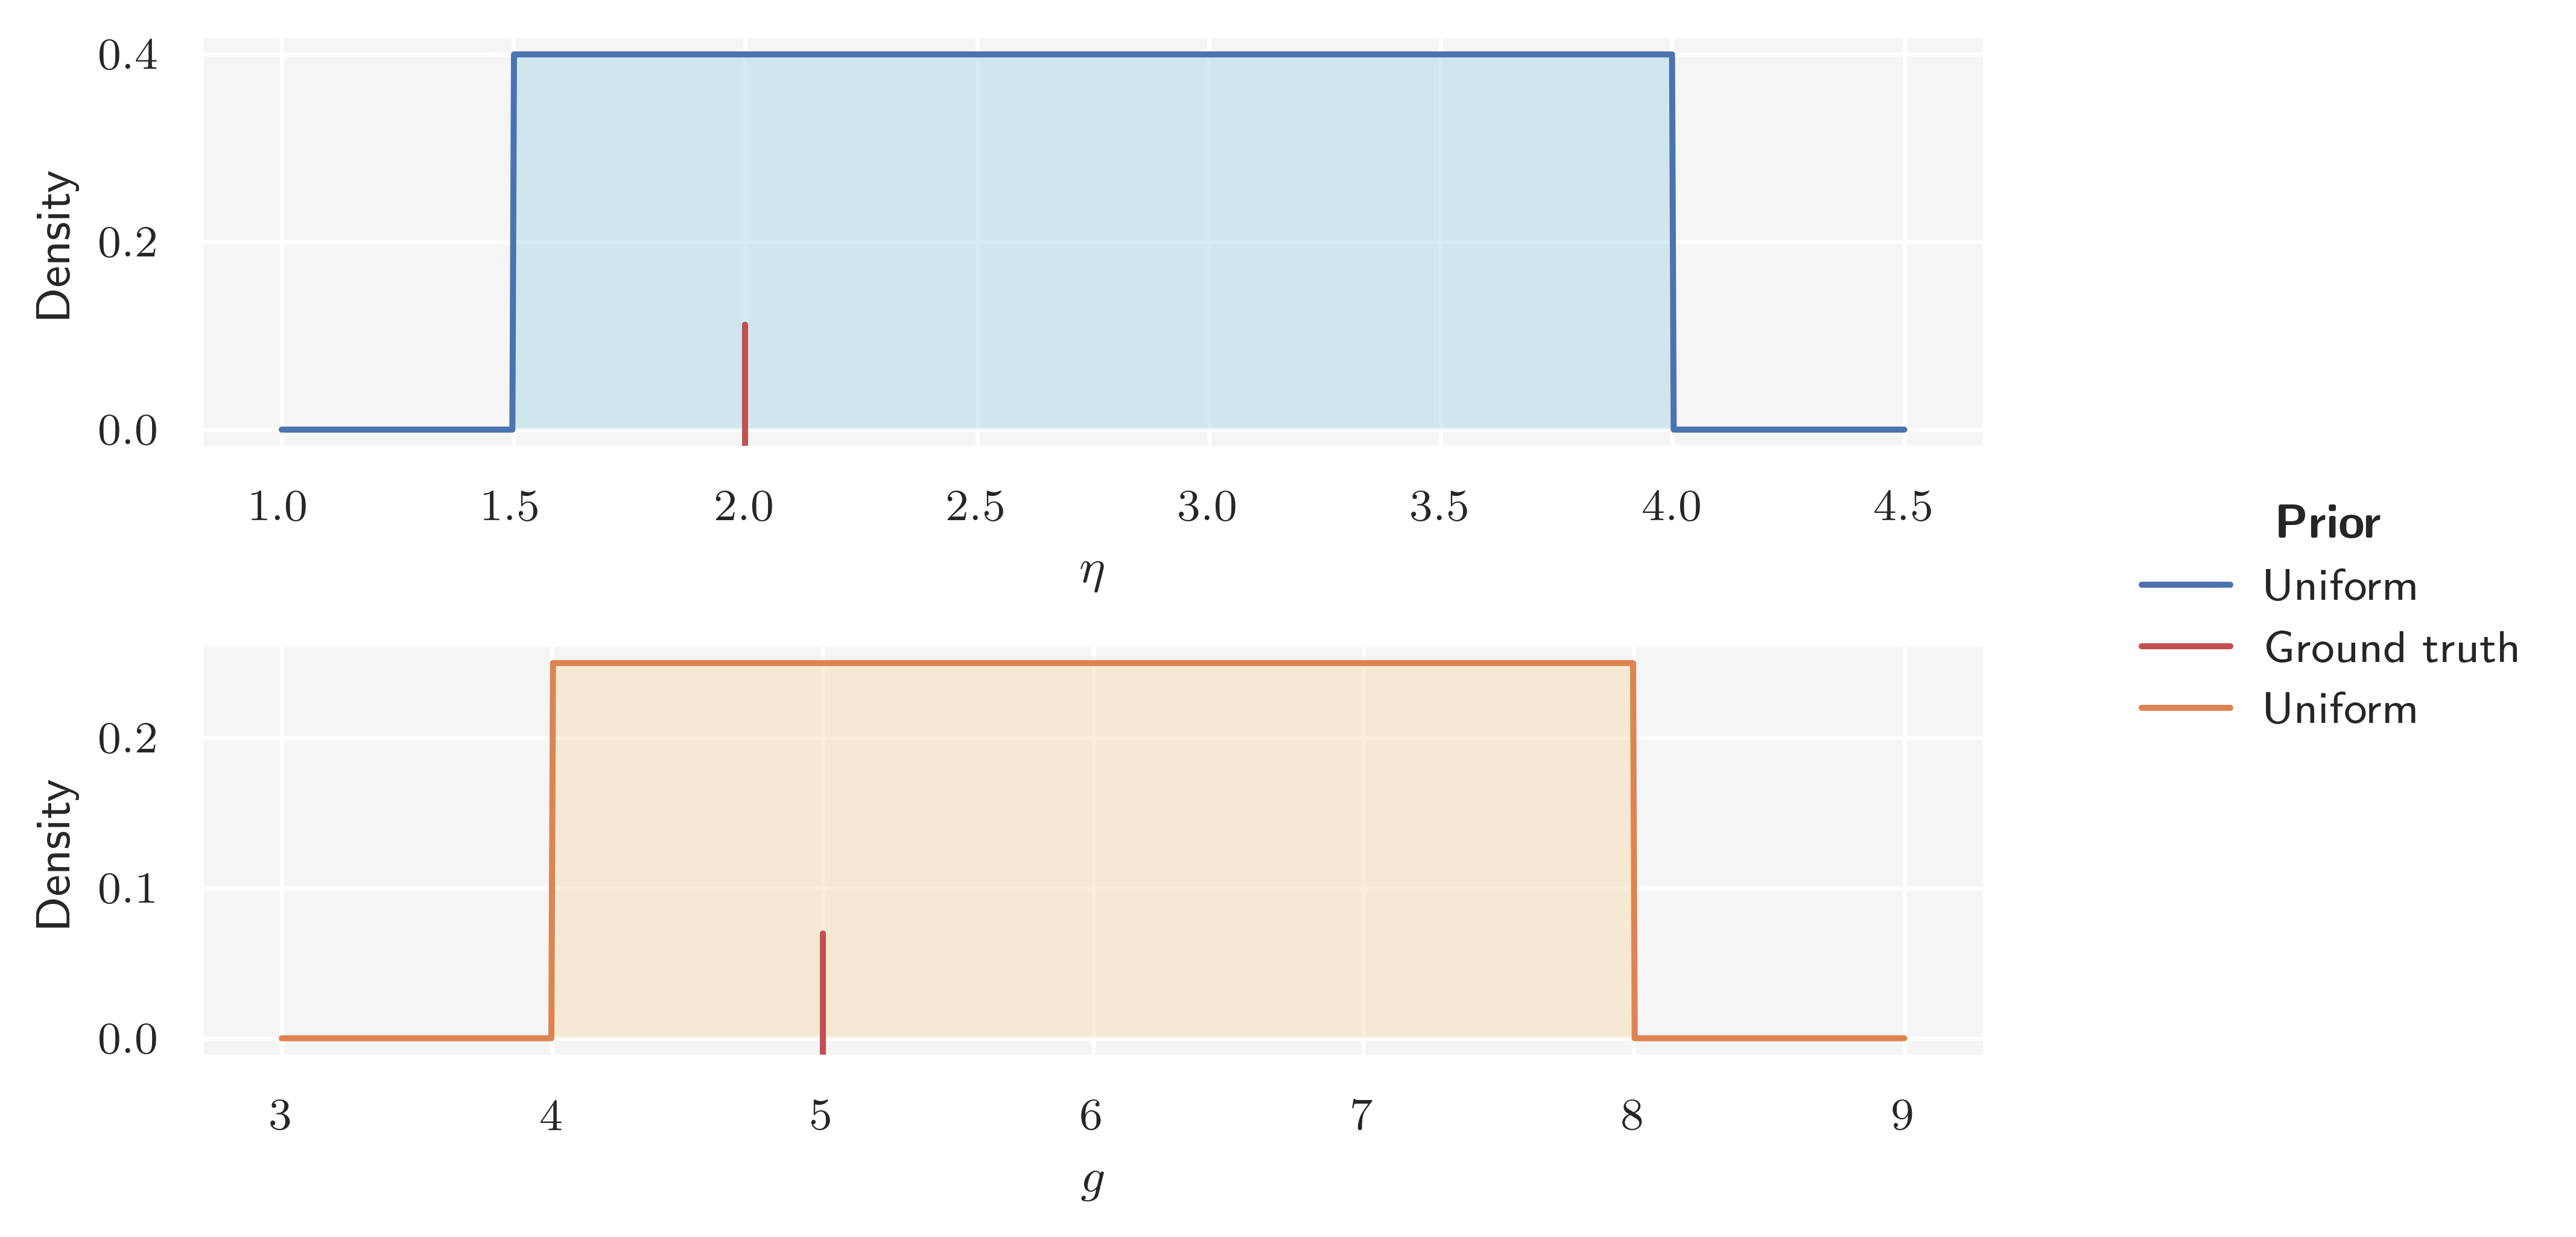

In [8]:
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

eta_prior = pylfi.Prior('uniform',
                        loc=1.5,
                        scale=2.5,
                        name='eta',
                        tex=r"$\eta$"
                        )

g_prior = pylfi.Prior('uniform',
                      loc=4,
                      scale=4,
                      name='g',
                      tex=r"$g$"
                      )

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)

ax1 = axes[0]
x = np.linspace(1, 4.5, 1000)
eta_prior.plot_prior(x, ax=ax1, label='Uniform')
ax1.axvline(eta_ai, ymax=0.3, color='r', label='Ground truth')
g, = ax1.plot([1], [0], color='C1', alpha=1, label='Uniform')

ax2 = axes[1]
x = np.linspace(3, 9, 1000)
g_prior.plot_prior(x, ax=ax2, color='C1', facecolor='wheat')
ax2.axvline(g_ai, ymax=0.3, color='r')

handles, labels = ax1.get_legend_handles_labels()

fig.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          frameon=False,
          title=r"\textbf{Prior}",
          ncol=1
         )

fig.savefig(fig_path('brunel_priors.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

## Simulation

In [9]:
df = pd.read_csv('data/brunel_ai_data.csv')
df

eta         g    $\eta$       $g$  mean_firing_rate   mean_cv  \
0     2.139653  6.040061  2.139653  6.040061          0.023944  0.549996   
1     1.768176  7.335284  1.768176  7.335284          0.011611  0.615821   
2     3.504035  5.147253  3.504035  5.147253          0.072833  0.443488   
3     3.067462  5.867245  3.067462  5.867245          0.043278  0.569711   
4     2.244444  4.588072  2.244444  4.588072          0.060722  0.353803   
...        ...       ...       ...       ...               ...       ...   
1995  2.123932  4.667643  2.123932  4.667643          0.053667  0.379671   
1996  3.668498  4.704150  3.668498  4.704150          0.103167  0.325364   
1997  2.725004  7.344014  2.725004  7.344014          0.024000  0.722976   
1998  1.808409  6.152027  1.808409  6.152027          0.018000  0.568184   
1999  2.552875  7.756716  2.552875  7.756716          0.017500  0.760488   

      fanofactor  
0       0.341667  
1       0.283333  
2       0.188276  
3       0.323256  
4       0.085153  
...          ...  
1995    0.106657  
1996    0.147708  
1997    0.628891  
1998    0.324504  
1999    0.447191  

[2000 rows x 7 columns]

### Check for missing values

In [10]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.isna().sum().to_frame("NaN count")

NaN count
eta                       0
g                         0
$\eta$                    0
$g$                       0
mean_firing_rate          0
mean_cv                   0
fanofactor                0

### Look at summary statistics

In [11]:
df.columns

Index(['eta', 'g', '$\eta$', '$g$', 'mean_firing_rate', 'mean_cv',
       'fanofactor'],
      dtype='object')

In [12]:
selected_columns = df[['$\eta$', '$g$', 'mean_firing_rate', 'mean_cv', 'fanofactor']]
df_stats = selected_columns.copy()
df_stats.rename(columns={"mean_firing_rate": "Mean firing rate",
                   "mean_cv": "Mean CV",
                   "fanofactor": "Fano factor"
                  },
          inplace=True
         )

df_stats

$\eta$       $g$  Mean firing rate   Mean CV  Fano factor
0     2.139653  6.040061          0.023944  0.549996     0.341667
1     1.768176  7.335284          0.011611  0.615821     0.283333
2     3.504035  5.147253          0.072833  0.443488     0.188276
3     3.067462  5.867245          0.043278  0.569711     0.323256
4     2.244444  4.588072          0.060722  0.353803     0.085153
...        ...       ...               ...       ...          ...
1995  2.123932  4.667643          0.053667  0.379671     0.106657
1996  3.668498  4.704150          0.103167  0.325364     0.147708
1997  2.725004  7.344014          0.024000  0.722976     0.628891
1998  1.808409  6.152027          0.018000  0.568184     0.324504
1999  2.552875  7.756716          0.017500  0.760488     0.447191

[2000 rows x 5 columns]

In [13]:
df_stats = df_stats.iloc[:len(df_stats.index)//4]  # plot subset only
df_stats

$\eta$       $g$  Mean firing rate   Mean CV  Fano factor
0    2.139653  6.040061          0.023944  0.549996     0.341667
1    1.768176  7.335284          0.011611  0.615821     0.283333
2    3.504035  5.147253          0.072833  0.443488     0.188276
3    3.067462  5.867245          0.043278  0.569711     0.323256
4    2.244444  4.588072          0.060722  0.353803     0.085153
..        ...       ...               ...       ...          ...
495  3.416425  4.954923          0.078944  0.403432     0.144275
496  3.135454  4.220128          0.132611  0.230601     0.083447
497  3.927176  7.061968          0.042556  1.098724     1.148229
498  3.788145  4.193933          0.163722  0.199150     0.022847
499  1.519287  7.800612          0.007500  0.607410     0.395638

[500 rows x 5 columns]

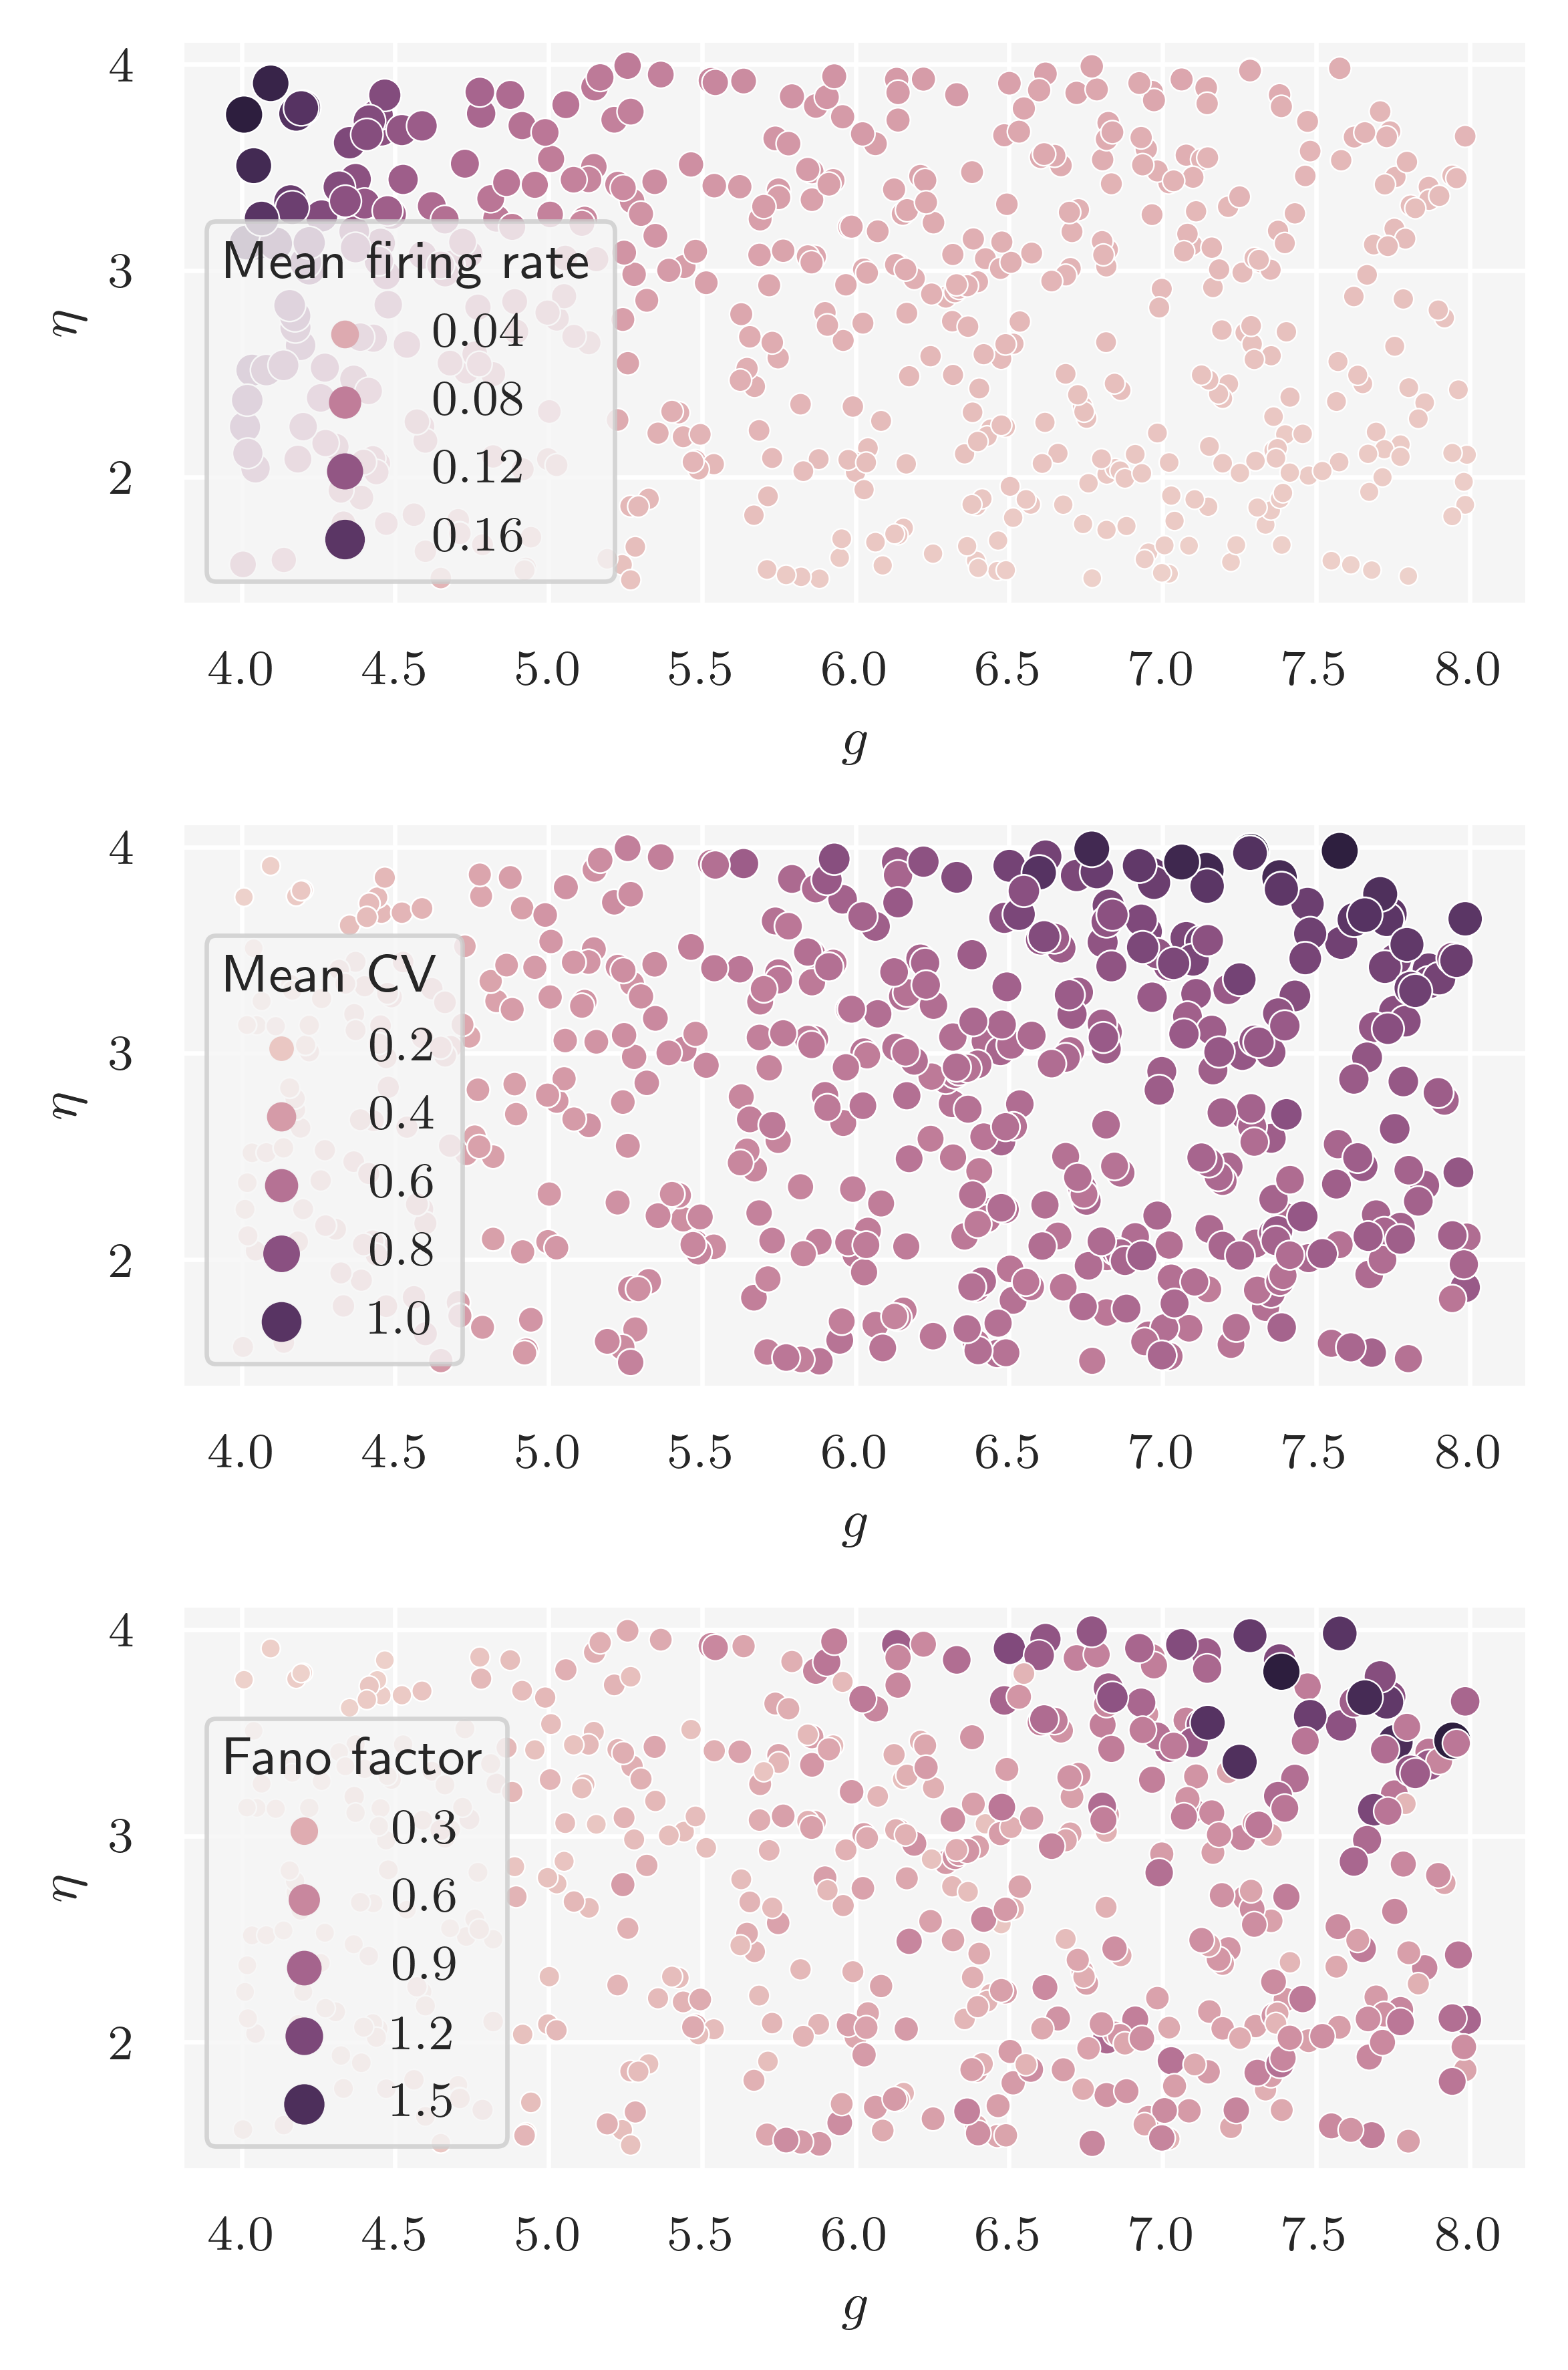

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4, 6), tight_layout=True, dpi=300)

# Mean firing rate
sns.scatterplot(data=df_stats, 
                x=r"$g$", 
                y=r"$\eta$", 
                hue="Mean firing rate",
                size="Mean firing rate",
                ax=axes[0]
               )


# Mean CV
sns.scatterplot(data=df_stats, 
                x=r"$g$", 
                y=r"$\eta$", 
                hue="Mean CV",
                size="Mean CV",
                ax=axes[1]
               )

# Fano factor
sns.scatterplot(data=df_stats, 
                x=r"$g$", 
                y=r"$\eta$", 
                hue="Fano factor",
                size="Fano factor",
                ax=axes[2]
               )

fig.savefig(fig_path('brunel_sum_stats.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Correlation

In [15]:
selected_columns = df[['$\eta$', '$g$', 'mean_firing_rate', 'mean_cv', 'fanofactor']]
df_stats = selected_columns.copy()
df_stats.rename(columns={"mean_firing_rate": "Mean firing rate",
                   "mean_cv": "Mean CV",
                   "fanofactor": "Fano factor"
                  },
          inplace=True
         )

df_stats

$\eta$       $g$  Mean firing rate   Mean CV  Fano factor
0     2.139653  6.040061          0.023944  0.549996     0.341667
1     1.768176  7.335284          0.011611  0.615821     0.283333
2     3.504035  5.147253          0.072833  0.443488     0.188276
3     3.067462  5.867245          0.043278  0.569711     0.323256
4     2.244444  4.588072          0.060722  0.353803     0.085153
...        ...       ...               ...       ...          ...
1995  2.123932  4.667643          0.053667  0.379671     0.106657
1996  3.668498  4.704150          0.103167  0.325364     0.147708
1997  2.725004  7.344014          0.024000  0.722976     0.628891
1998  1.808409  6.152027          0.018000  0.568184     0.324504
1999  2.552875  7.756716          0.017500  0.760488     0.447191

[2000 rows x 5 columns]

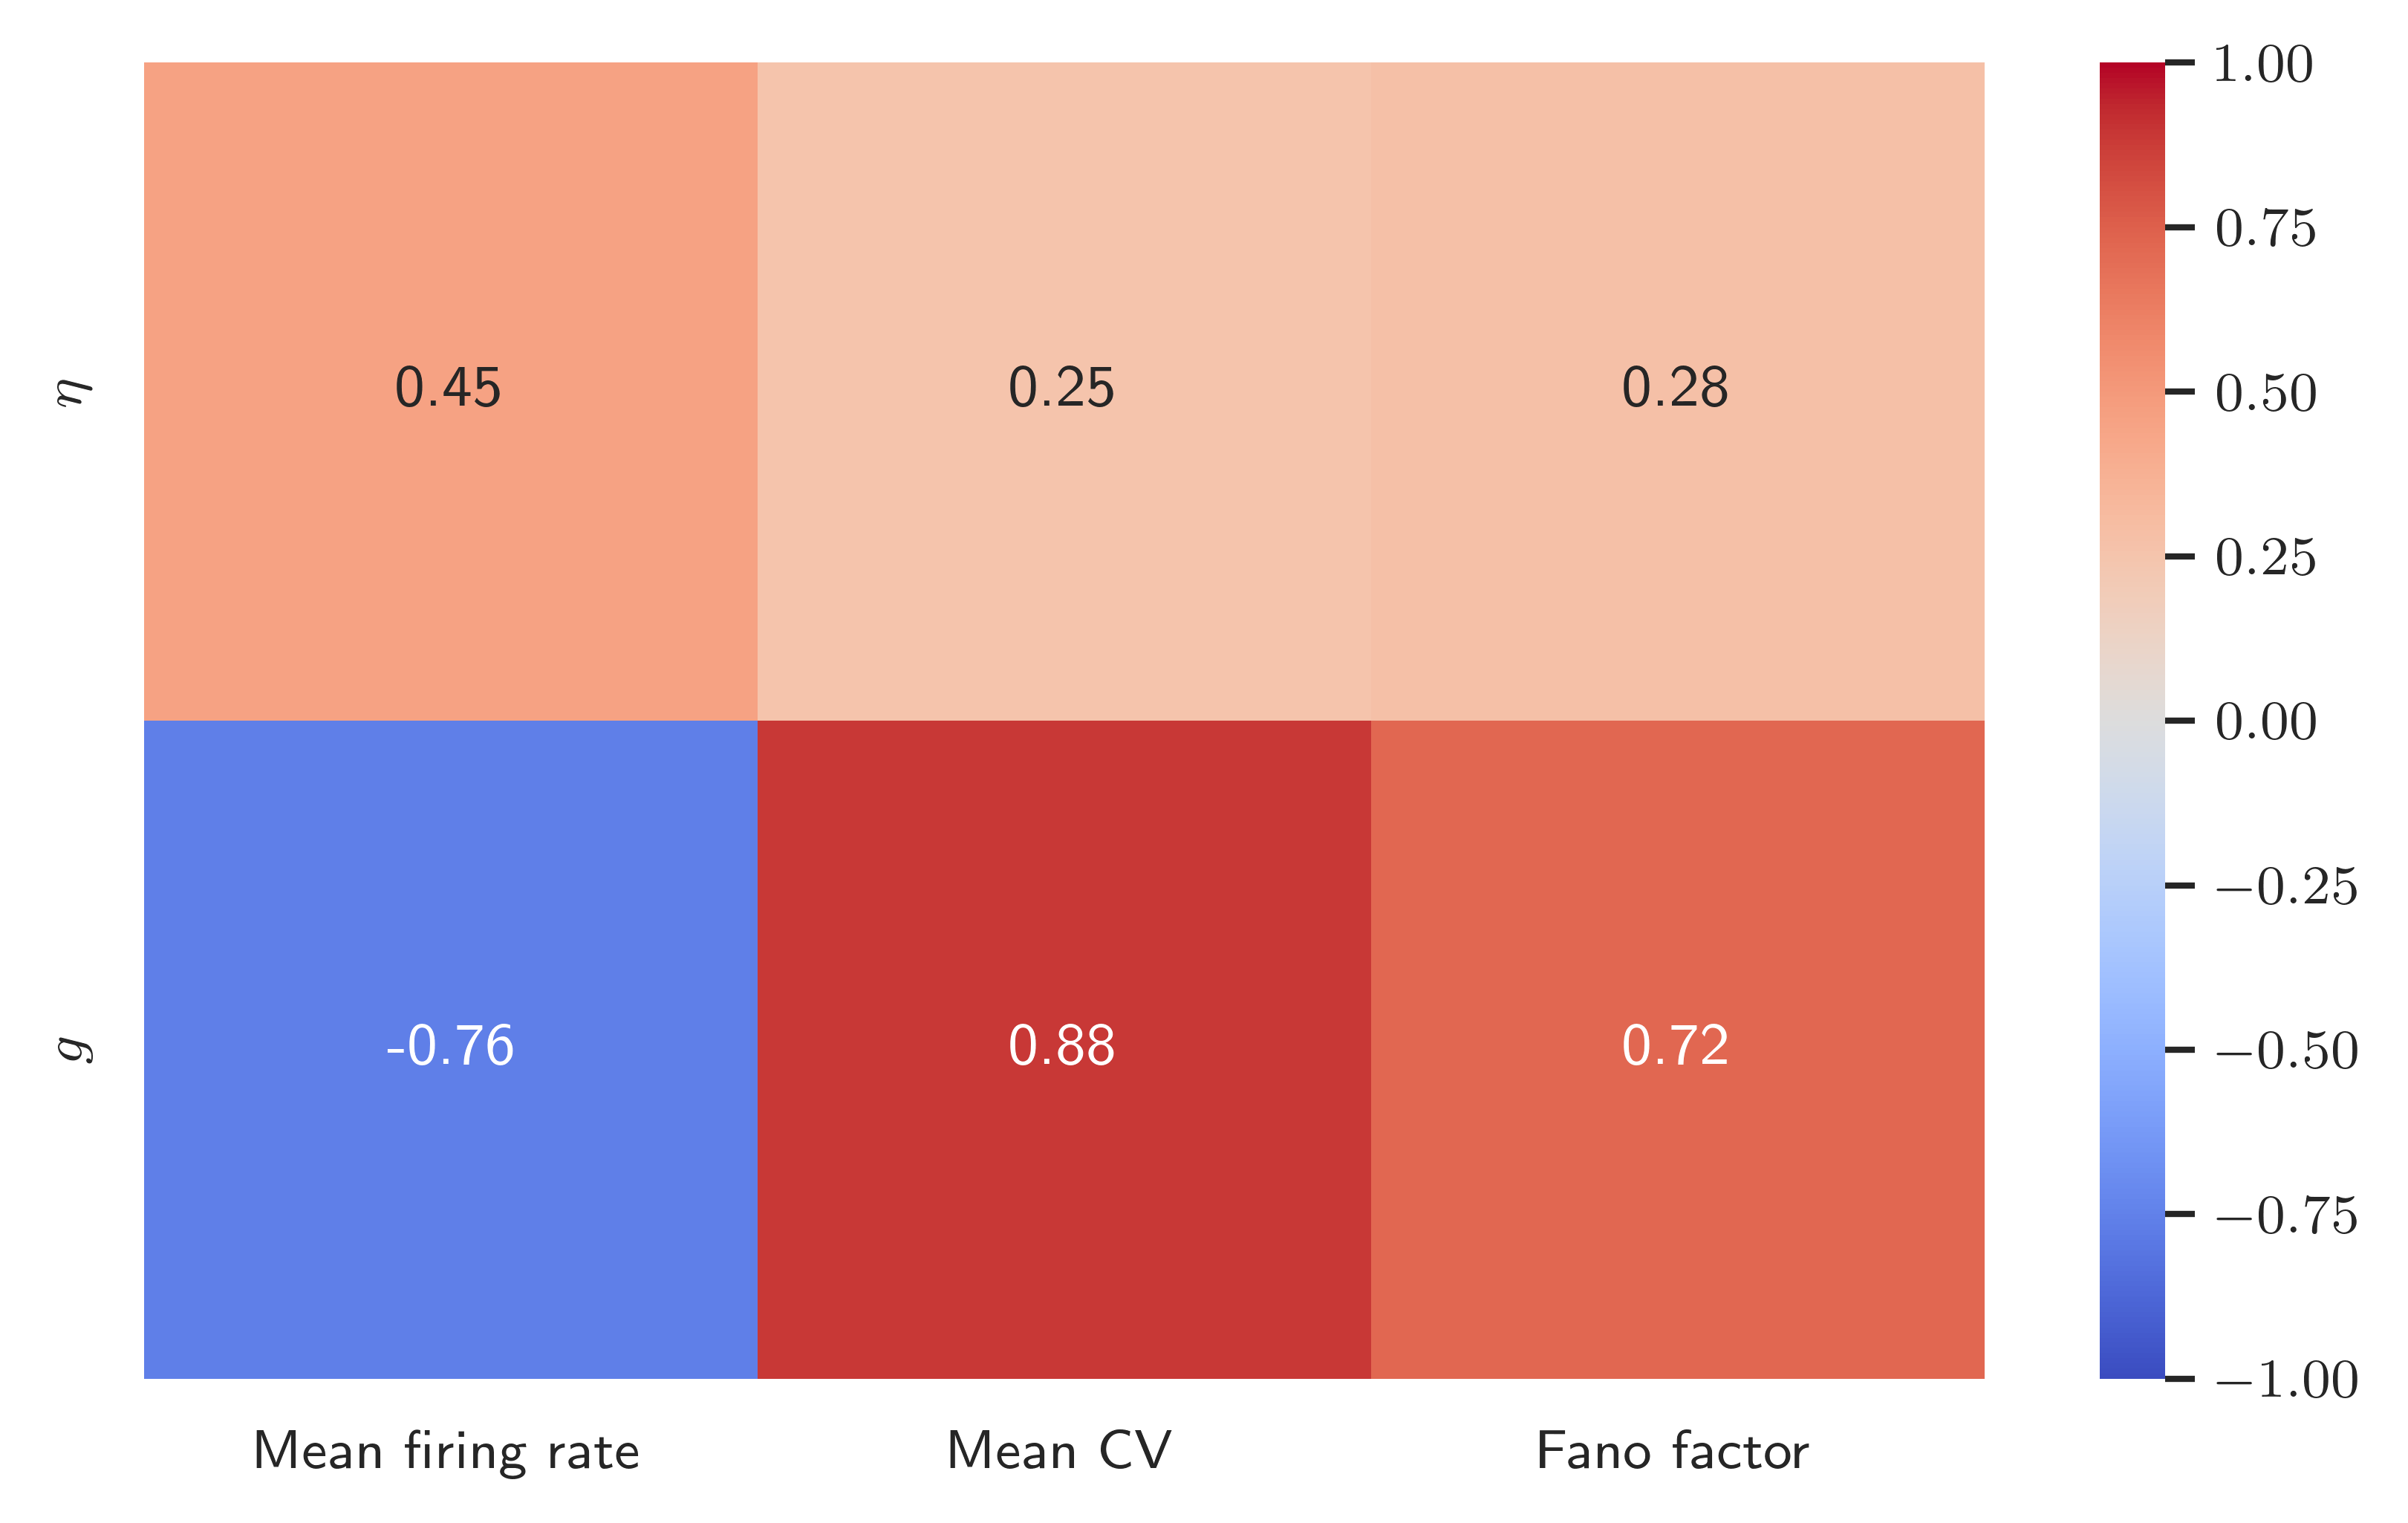

In [16]:
corr = df_stats.corr()

corr.drop(r"$g$", axis=1, inplace=True)
corr.drop(r"$\eta$", axis=1, inplace=True)
corr.drop("Mean firing rate", axis=0, inplace=True)
corr.drop("Mean CV", axis=0, inplace=True)
corr.drop("Fano factor", axis=0, inplace=True)

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
sns.heatmap(corr, ax=ax, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

fig.savefig(fig_path('brunel_sum_stats_corr.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Compute weights

In [17]:
weights = []
for col in corr.columns:
    r_eta = corr[col].iloc[0]
    r2_eta = r_eta**2 
    
    r_g = corr[col].iloc[1]
    r2_g = r_g**2 
    
    weight = np.mean([r2_eta, r2_g])
    weights.append(weight) 
    
df_weights = pd.DataFrame(data=weights,
                          columns=["Weight"],
                          index=corr.columns
                         )

# ensure that weights sum to 1
df_weights /= df_weights["Weight"].sum()

df_weights

Weight
Mean firing rate  0.354215
Mean CV           0.378770
Fano factor       0.267015

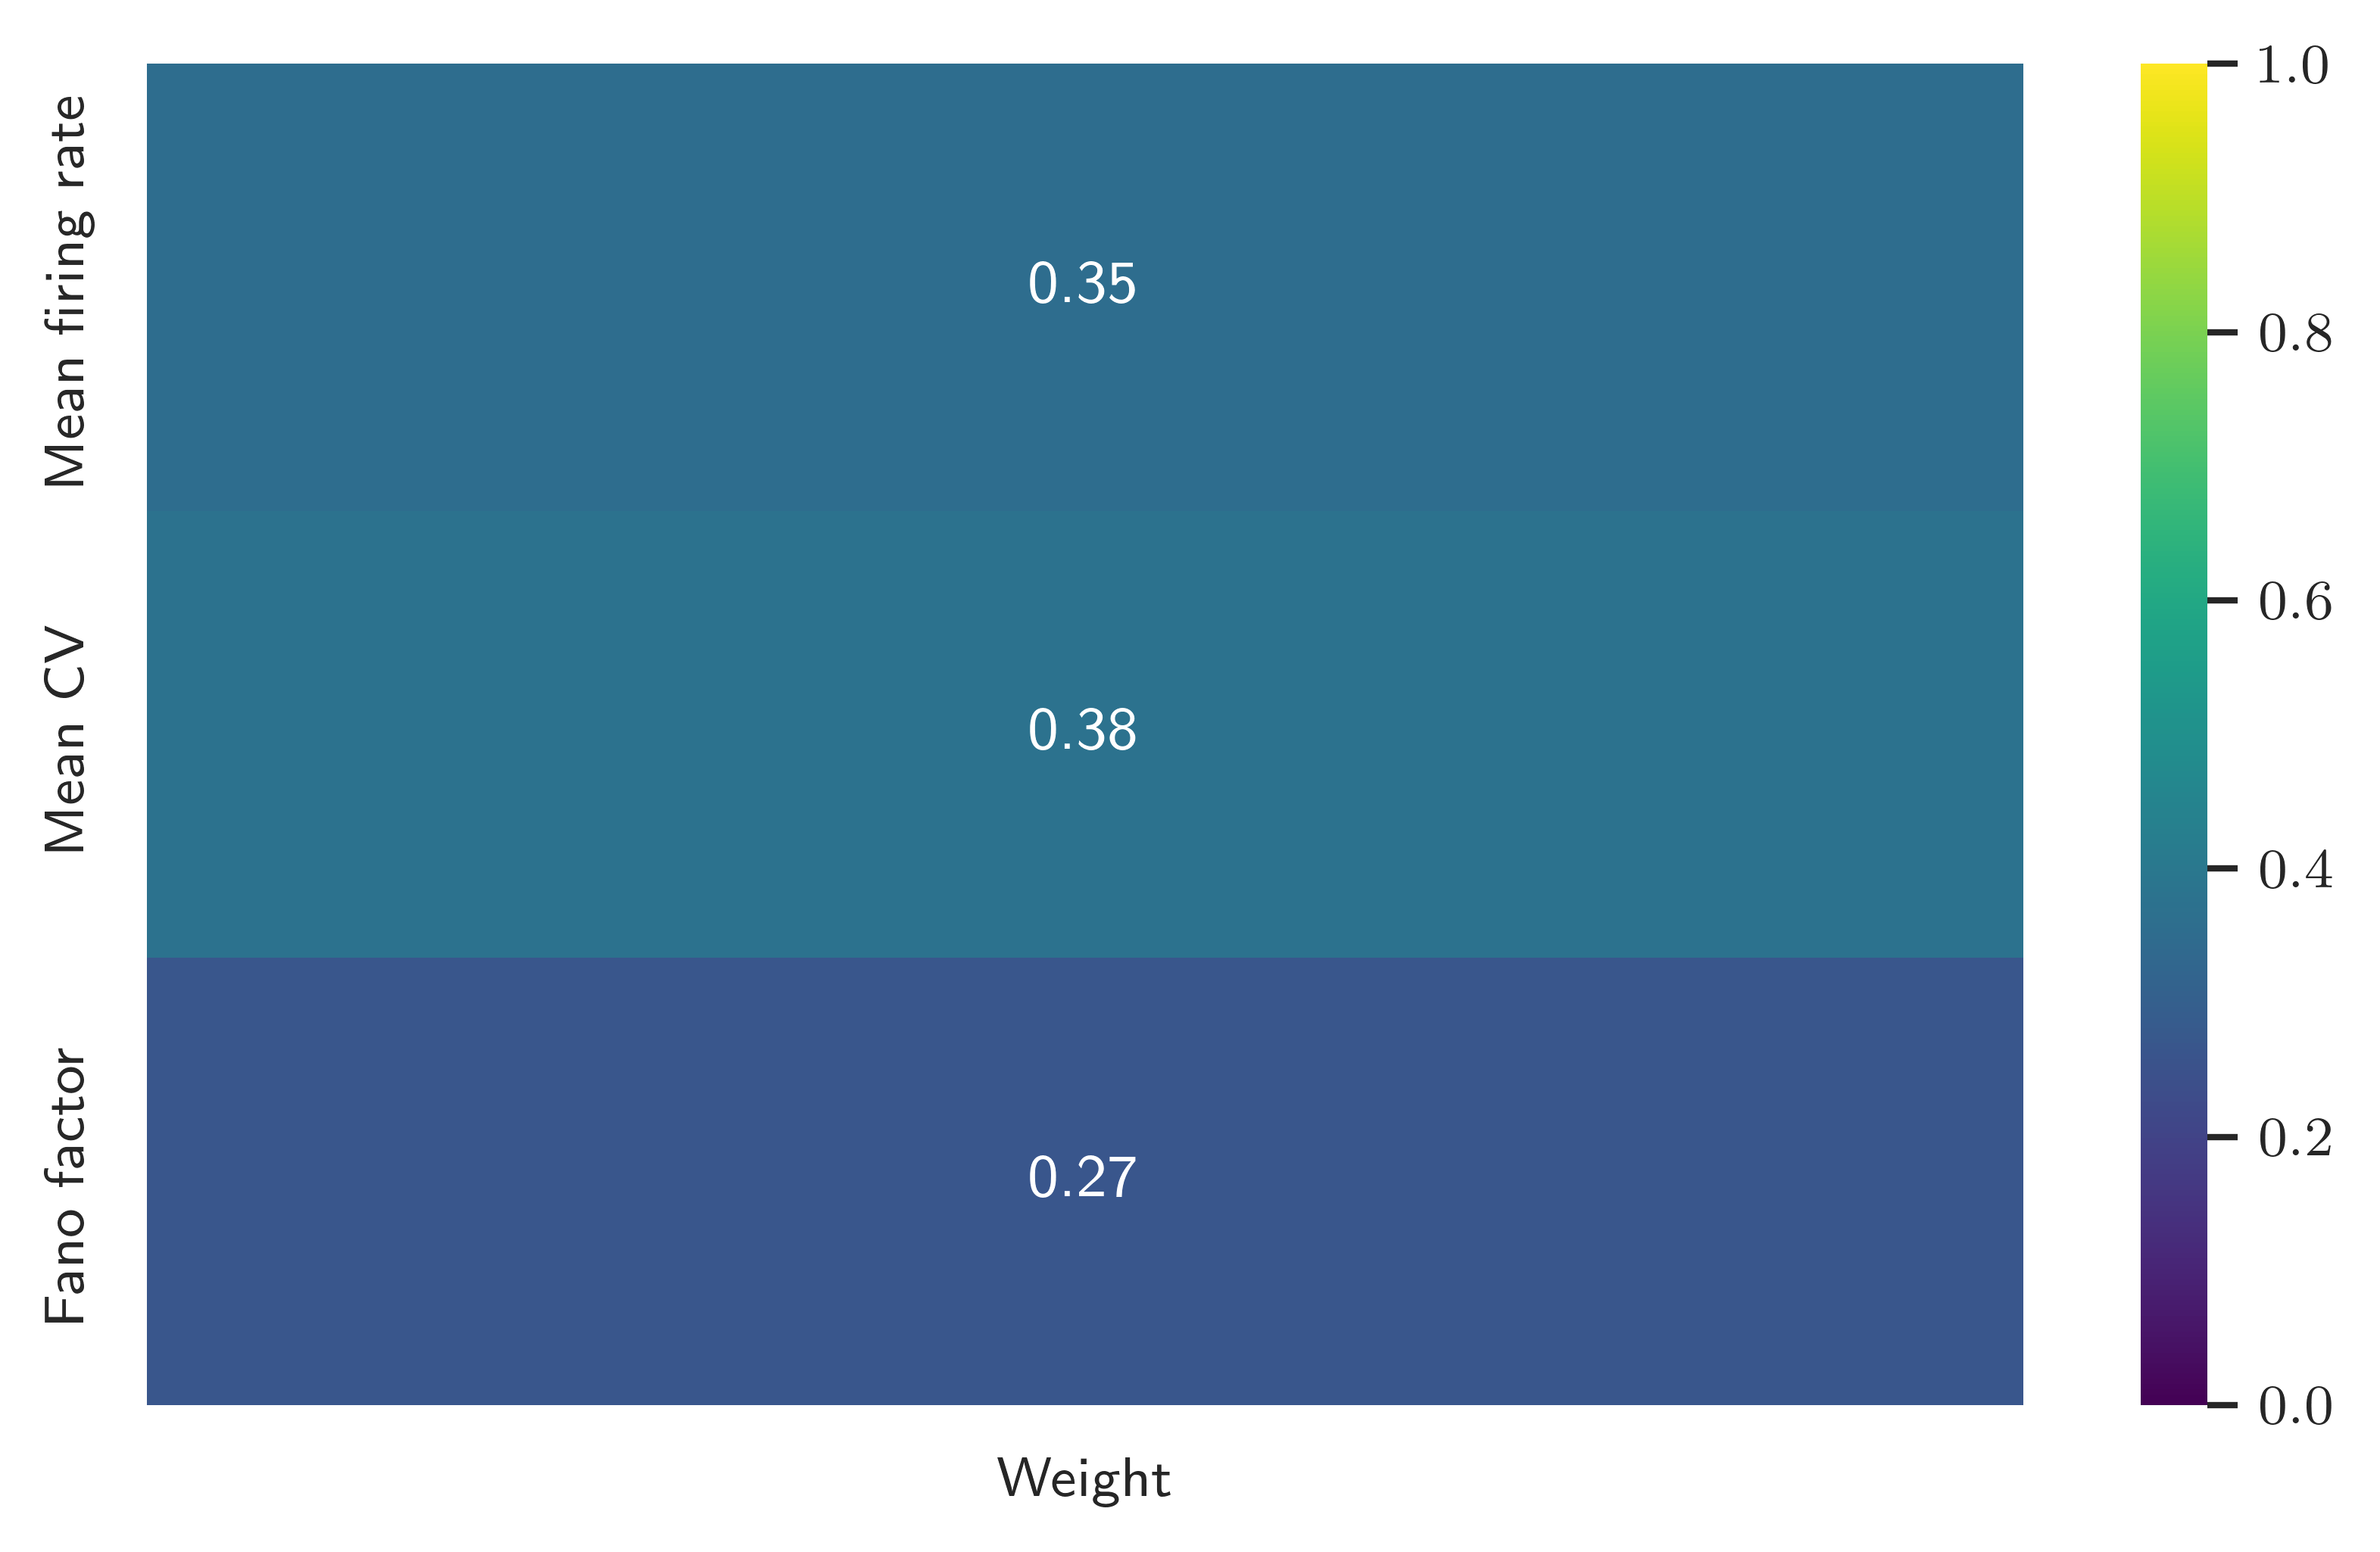

In [18]:
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
sns.heatmap(df_weights, ax=ax, annot=True, cmap='viridis', vmin=0, vmax=1)

fig.savefig(fig_path('brunel_sum_stats_weights.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Scale

In [19]:
def sd(a, axis=0):    
    """Standard deviation from the mean"""
    a = np.asarray(a, dtype=float)
    a[a == np.inf] = np.NaN
    sd = np.sqrt(np.nanmean(np.abs(a - np.nanmean(a, axis=axis))**2, axis=axis))
    return sd

In [20]:
df = pd.read_csv('data/brunel_ai_data.csv')
s_stats = ["mean_firing_rate",  # rate estimation
           "mean_cv",           # spike interval statistic
           "fanofactor"         # statistic across spike trains
           ]
sum_stats = df[s_stats].to_numpy()
print(sum_stats)

[[0.02394444 0.54999643 0.34166667]
 [0.01161111 0.61582063 0.28333333]
 [0.07283333 0.44348815 0.18827586]
 ...
 [0.024      0.72297627 0.62889126]
 [0.018      0.56818381 0.32450425]
 [0.0175     0.76048784 0.44719101]]


In [21]:
stat_scale = sd(sum_stats)
print(stat_scale)

[0.03473533 0.20253095 0.33193481]


## Inference on simulation 

### Functions

In [22]:
def distance(s_sim, s_obs, weight=1., scale=1.):
    """Weighted Euclidean distance."""

    s_sim = np.asarray(s_sim, dtype=float)
    s_obs = np.asarray(s_obs, dtype=float)

    q = np.sqrt(weight) * (s_sim - s_obs) / scale
    dist = np.linalg.norm(q, ord=2)

    return dist

def epkov_kernel(d, h):
    """Epanechnikov smoothing kernel function"""
    return (1.0 - (d * d) / (h * h)) * (d < h)

def compute_rmspe(theta_true, theta_pred):
    """Root mean square percentage error (RMSPE)"""
    rmspe = np.sqrt(np.mean(np.square((theta_true - theta_pred) / theta_true)))
    return rmspe * 100

def compute_point_est(theta, density, point_estimate):
    """Compute point estimate"""
    if point_estimate == "mean":
        p_est = theta.mean()
        handle = "mean"
    elif point_estimate == "median":
        p_est = np.median(theta)
        handle = "median"
    elif point_estimate == "map":
        idx = np.argmax(density)
        p_est = theta[idx]
        handle = "MAP"
    return p_est, handle

def compute_hdi(theta, hdi_prob):
    """Highest (posterior) density interval"""
    theta = theta.flatten()
    n = len(theta)
    theta = np.sort(theta)
    interval_idx_inc = int(np.floor(hdi_prob * n))
    n_intervals = n - interval_idx_inc
    interval_width = np.subtract(theta[interval_idx_inc:],
                                 theta[:n_intervals],
                                 dtype=np.float_
                                 )
    min_idx = np.argmin(interval_width)
    hdi_min = theta[min_idx]
    hdi_max = theta[min_idx + interval_idx_inc]
    return (hdi_min, hdi_max)


def plot_posterior(df, theta_name, theta_true, point_estimate='map', hdi_prob=0.95, ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    xdata = df[theta_name].to_numpy() 
    theta_true_ary = np.ones(len(xdata.flatten())) * theta_true
    rmspe = compute_rmspe(theta_true_ary, xdata)
    
    sns.kdeplot(data=df,
                x=theta_name,
                color='C0',
                label=f"Posterior RMSPE: {rmspe:.2f}\%",
                ax=ax
            )

    ax.axvline(theta_true,
               ymax=0.3,
               color='C3',
               label=fr"$\theta_\mathrm{{true}}: {theta_true}$"
              )
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()

    p_est, p_est_handle = compute_point_est(xs, ys, point_estimate)

    hdi_min, hdi_max = compute_hdi(xdata, hdi_prob=hdi_prob)

    ax.vlines(
        p_est,
        0,
        np.interp(p_est, xs, ys),
        color='b',
        ls=':',
        label=fr"$\hat{{\theta}}_\mathrm{{{p_est_handle}}}: {p_est:.3f}$"
    )

    ax.fill_between(
        xs,
        0,
        ys,
        facecolor='lightblue',
        alpha=0.3
    )

    ax.fill_between(
        xs,
        0,
        ys,
        where=(hdi_min <= xs) & (xs <= hdi_max),
        interpolate=True,
        facecolor='steelblue',
        alpha=0.3,
        label=f"{hdi_prob*100}\% HDI: [{hdi_min:.3f}, {hdi_max:.3f}]"
    )

    handles, labels = ax.get_legend_handles_labels()

    ax.set(yticks=[])

    ax.legend(
        handles,
        labels,
        loc='center left',
        bbox_to_anchor=(1.04, 0.5),
        fancybox=True,
        borderaxespad=0.1,
        ncol=1,
        frameon=False
    )
    
    
def plot_joint(df, theta1_name, theta2_name, theta1_true=None, theta2_true=None, levels=6, alpha=0.3, height=4, **kwargs):

    g = sns.jointplot(
        data=df,
        x=theta1_name,
        y=theta2_name,
        kind="kde",
        fill=True,
        height=height,
        **kwargs
    )

    g.plot_joint(
        sns.kdeplot,
        color="k",
        levels=levels,
        alpha=alpha
    )

    if theta1_true is not None and theta2_true is not None:
        g.ax_joint.plot([theta1_true], [theta2_true], 'ro')
        g.ax_joint.axvline(theta1_true, color='r', ls=":")
        g.ax_joint.axhline(theta2_true, color='r', ls=":")
        g.ax_marg_x.axvline(theta1_true, color='r')
        g.ax_marg_y.axhline(theta2_true, color='r')

    return g

### Observed summary statistics

In [23]:
# observation

spiketrains = load_spiketrain('data/obs_ai_data.pkl')

# statistics calculator
s_stats = ["mean_firing_rate",  # rate estimation
           "mean_cv",           # spike interval statistic
           "fanofactor"         # statistic across spike trains
           ]

t_start = 100. * pq.ms
t_stop = T * pq.ms

sts = nm.statistics.SpikeTrainStats(stats=s_stats,
                                    t_start=t_start,
                                    t_stop=t_stop
                                    )

s_obs = sts(spiketrains)
print(s_obs)

[0.03661111111111111, 0.42506007658105566, 0.23413793103448277]


### Summary statistics weights and scales

In [24]:
stat_weights = df_weights["Weight"].to_numpy()
stat_scale = sd(sum_stats)
print(stat_weights)
print(stat_scale)

[0.3542154  0.37876988 0.26701472]
[0.03473533 0.20253095 0.33193481]


### Quantile analysis

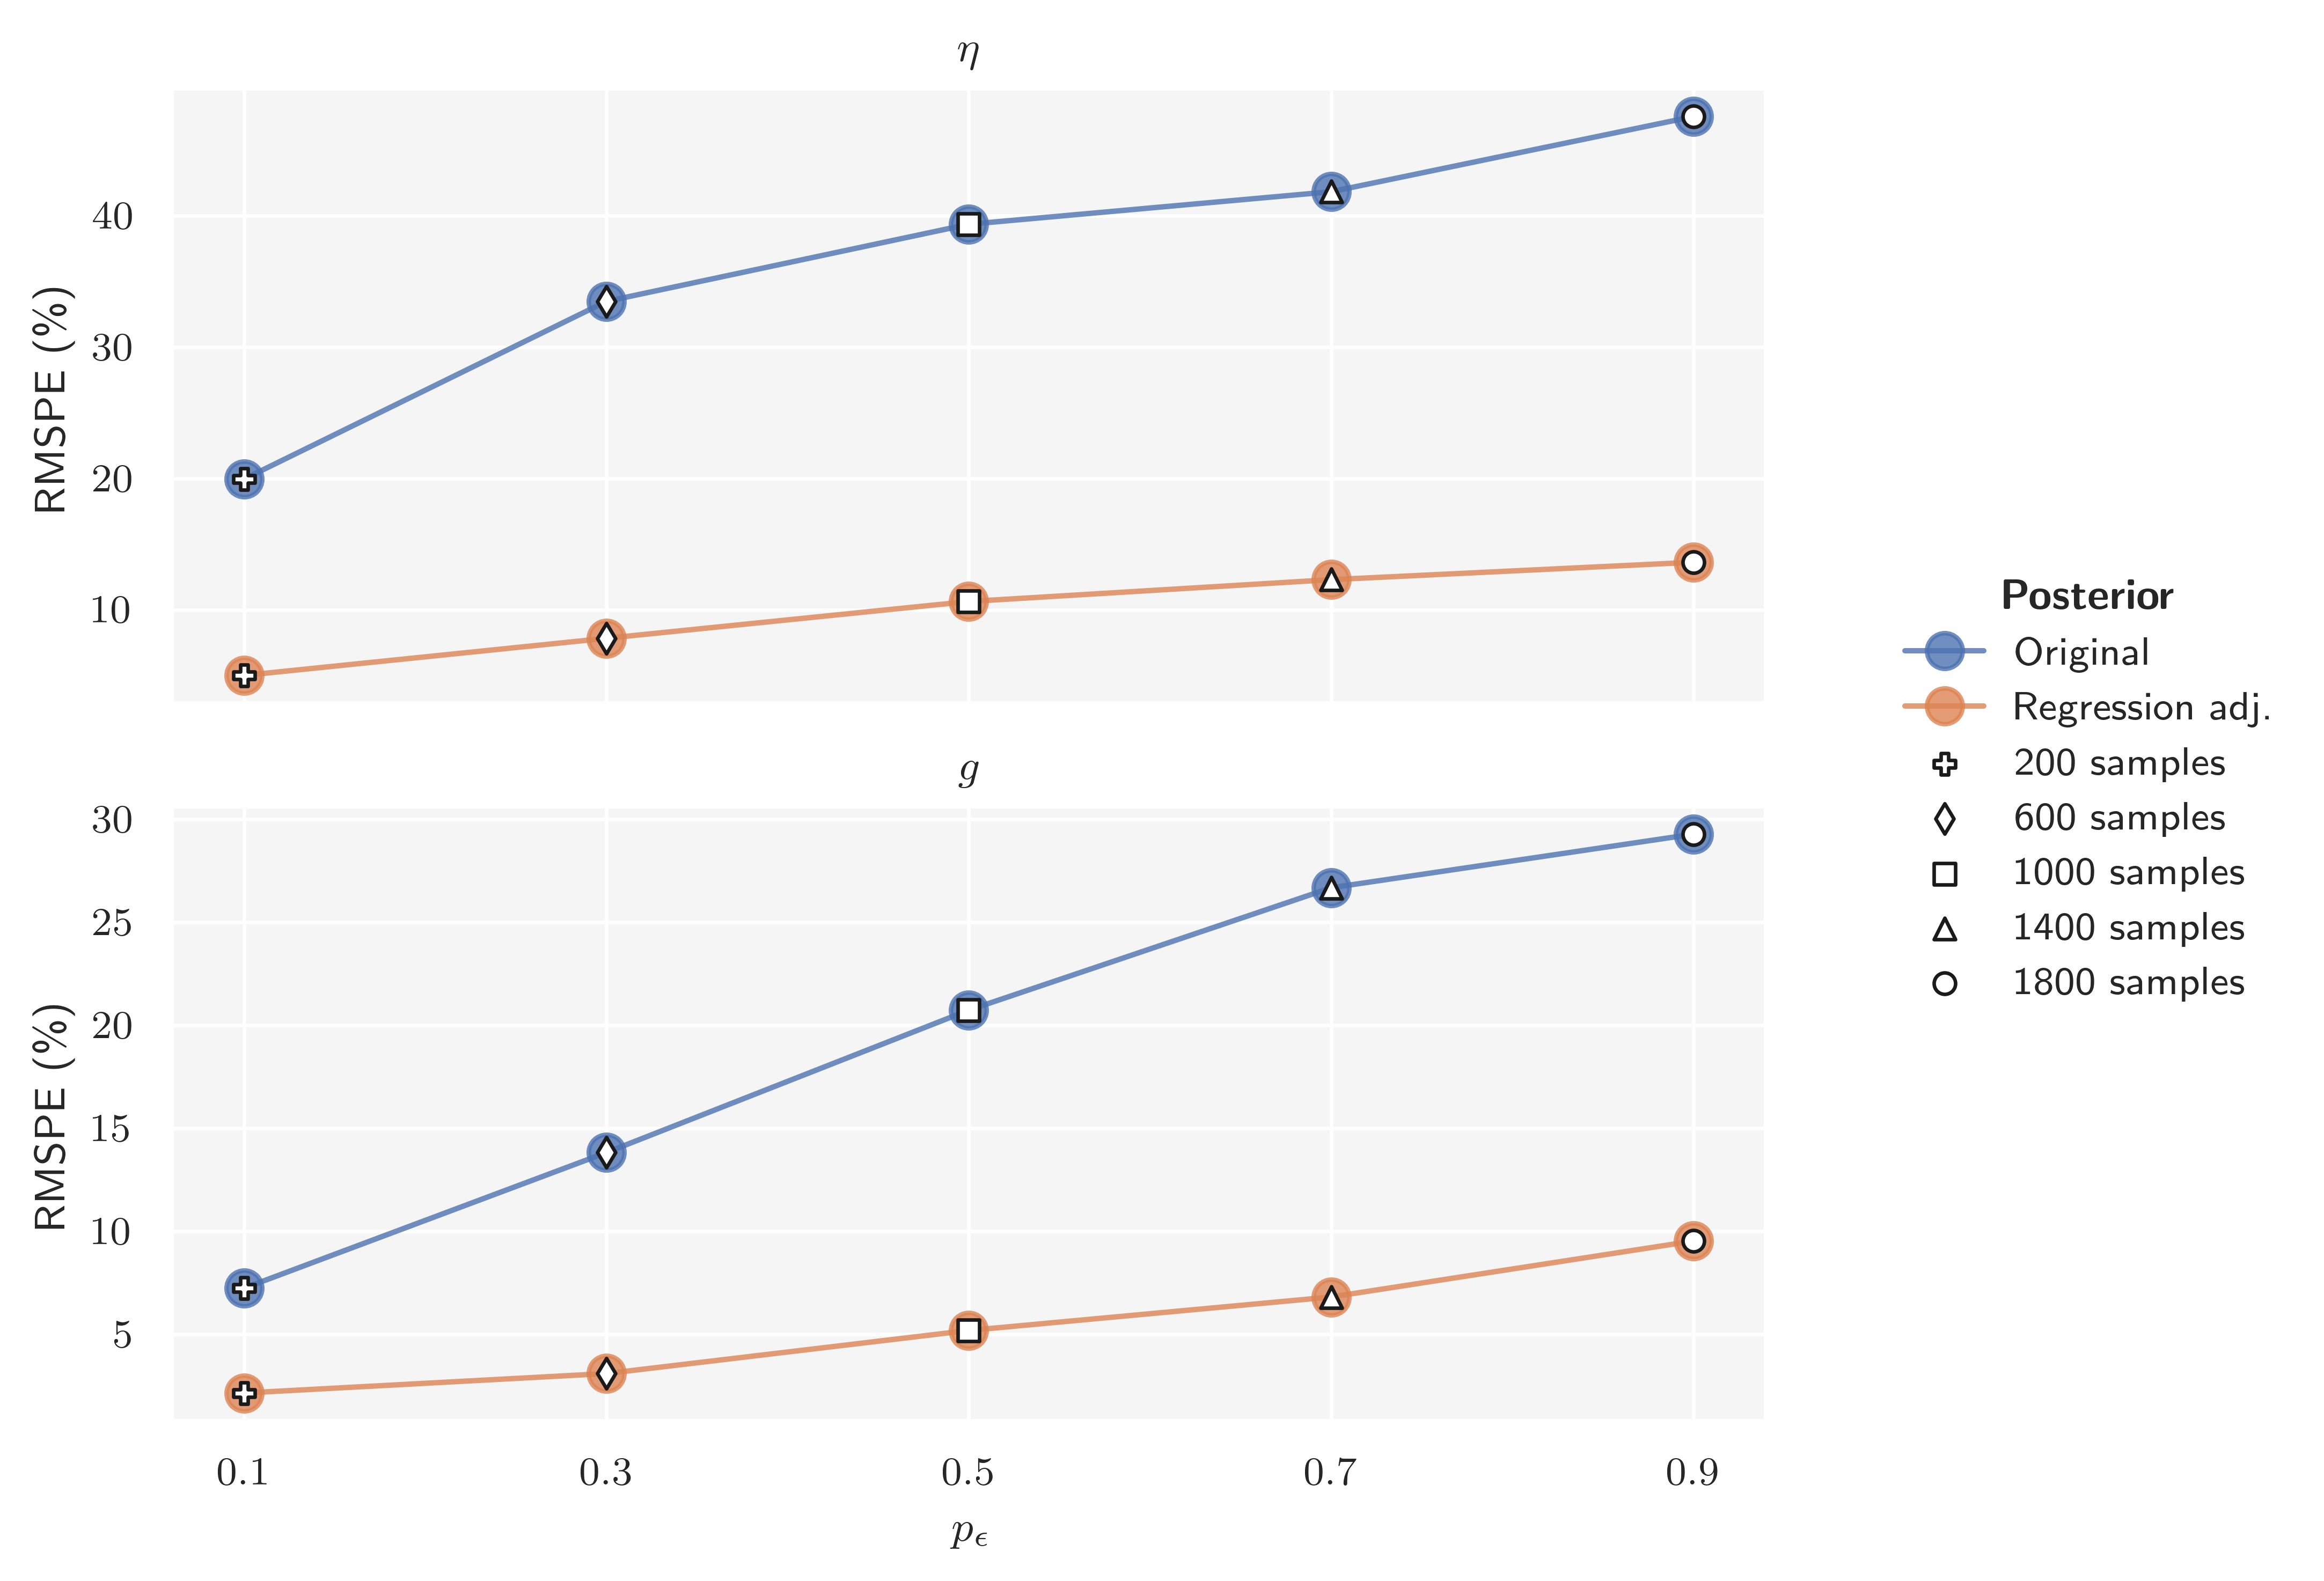

In [25]:
df = pd.read_csv('data/brunel_ai_data.csv')
s_stats = ["mean_firing_rate",  # rate estimation
           "mean_cv",           # spike interval statistic
           "fanofactor"         # statistic across spike trains
           ]
sum_stats_q = df[s_stats].to_numpy()
thetas_q = df[["eta", "g"]].to_numpy()

stat_weights_q = df_weights["Weight"].to_numpy()
stat_scale_q = sd(sum_stats)

distances_q = []
for s_sim_q in sum_stats_q:
    dist_q = distance(s_sim_q, s_obs, weight=stat_weights_q, scale=stat_scale_q)
    distances_q.append(dist_q)
    
distances_q = np.array(distances_q, dtype=np.float64)

eta_true = 2.
g_true = 5.

quantile_lst = [0.1, 0.3, 0.5, 0.7, 0.9] 

eta_rmspe_org_lst = []
g_rmspe_org_lst = []

eta_rmspe_reg_lst = []
g_rmspe_reg_lst = []

n_samples_lst = []

for quantile in quantile_lst: 
    
    # acceptance criterion
    epsilon_q = np.nanquantile(distances_q, quantile)
    is_accepted_q = distances_q < epsilon_q
    
    # accepted simulations
    thetas_accept_q = thetas_q[is_accepted_q]
    dist_accept_q = distances_q[is_accepted_q]
    sum_stats_accept_q = sum_stats_q[is_accepted_q]

    n_samples_q = thetas_accept_q.shape[0]
    n_samples_lst.append(n_samples_q)
    
    # true value arrays
    eta_true_ary = np.ones(n_samples_q) * eta_true 
    g_true_ary = np.ones(n_samples_q) * g_true 
    
    # original samples 
    eta_rmspe_org = compute_rmspe(eta_true_ary, thetas_accept_q[:, 0])
    g_rmspe_org = compute_rmspe(g_true_ary, thetas_accept_q[:, 1])
    
    eta_rmspe_org_lst.append(eta_rmspe_org)
    g_rmspe_org_lst.append(g_rmspe_org)
    
    # regression adjustment
    X = copy.deepcopy(sum_stats_accept_q)
    
    factor_q = stat_weights_q / stat_scale_q
    X *= factor_q

    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # augment with column of ones
    X = np.c_[np.ones(X.shape[0]), X]

    # target
    thetas_reg_q = copy.deepcopy(thetas_accept_q)

    # transform:
    thetas_reg_q = np.log(thetas_reg_q)

    # smoothing kernel weights
    kernel_weights_q = np.array([epkov_kernel(d, epsilon_q) for d in dist_accept_q])

    # Weight matrix
    W = np.diag(kernel_weights_q) 

    # compute coefficients (pinv = pseudo-inverse)
    #coef = np.linalg.pinv(X.T @ X)  @ X.T @ thetas
    coef_q = np.linalg.pinv(X.T @ (W @ X)) @ X.T @ (W @ thetas_reg_q)
    alpha_q = coef_q[0]
    beta_q = coef_q[1:]

    # adjust posterior samples
    s_sim_reg_q = sum_stats_accept_q * factor_q
    s_obs_reg_q = s_obs * factor_q
    correction = (s_sim_reg_q - s_obs_reg_q) @ beta_q

    thetas_adj_q = np.exp(np.log(thetas_accept_q) - correction)
    
    # rmspe
    eta_rmspe_reg = compute_rmspe(eta_true_ary, thetas_adj_q[:, 0])
    g_rmspe_reg = compute_rmspe(g_true_ary, thetas_adj_q[:, 1])
    
    eta_rmspe_reg_lst.append(eta_rmspe_reg)
    g_rmspe_reg_lst.append(g_rmspe_reg)
    
    
markers = [u'P', u'd', u's', u'^', u'o'] 

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(fs[0], 5), tight_layout=True, dpi=300, sharex=True)

ax = axes[0]

ax.plot(quantile_lst, eta_rmspe_org_lst, '-o', markersize=8, alpha=0.8, label='Original', zorder=1)
ax.plot(quantile_lst, eta_rmspe_reg_lst, '-o', markersize=8, alpha=0.8, label='Regression adj.', zorder=1)
for _q, _eta, _m, _n_samp in zip(quantile_lst, eta_rmspe_org_lst, markers, n_samples_lst):
    ax.scatter(_q, _eta, marker=_m, c='w', edgecolors='k', label=f'{_n_samp} samples', zorder=2)
    
for _q, _eta, _m in zip(quantile_lst, eta_rmspe_reg_lst, markers):
    ax.scatter(_q, _eta, marker=_m, c='w', edgecolors='k', zorder=2)
    
ax.set(ylabel="RMSPE (\%)",
       title=r'$\eta$'
       )

ax2 = axes[1]

ax2.plot(quantile_lst, g_rmspe_org_lst, '-o', markersize=8, alpha=0.8, zorder=1)
ax2.plot(quantile_lst, g_rmspe_reg_lst, '-o', markersize=8, alpha=0.8, zorder=1)

for _q, _g, _m in zip(quantile_lst, g_rmspe_org_lst, markers):
    ax2.scatter(_q, _g, marker=_m, c='w', edgecolors='k', zorder=2)

for _q, _g, _m in zip(quantile_lst, g_rmspe_reg_lst, markers):
    ax2.scatter(_q, _g, marker=_m, c='w', edgecolors='k', zorder=2)

ax2.set(xticks=quantile_lst,
       xlabel=r'$p_{\epsilon}$',
       ylabel="RMSPE (\%)",
       title=r'$g$'
       )
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='center left',
    title=r"\textbf{Posterior}",
    bbox_to_anchor=(1.04, 0.5),
    fancybox=True,
    borderaxespad=0.1,
    ncol=1,
    frameon=False
)


fig.savefig(fig_path('brunel_quantile_rmspe.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Compute distances

In [26]:
distances = []
for s_sim in sum_stats:
    dist = distance(s_sim, s_obs, weight=stat_weights, scale=stat_scale)
    distances.append(dist)

### Find threshold as p-quantile of distances

In [27]:
quantile = 0.3

distances = np.array(distances, dtype=np.float64)
epsilon = np.nanquantile(distances, quantile)

print(epsilon)

0.5872459285657696


### Accept/reject simulations

In [28]:
df_thetas = pd.read_csv('data/brunel_ai_data.csv')
thetas = df_thetas[["eta", "g"]].to_numpy()
print(thetas)

[[2.13965294 6.04006082]
 [1.76817597 7.33528368]
 [3.50403535 5.14725286]
 ...
 [2.72500387 7.34401354]
 [1.80840922 6.15202658]
 [2.55287539 7.7567157 ]]


In [29]:
# acceptance criterion
is_accepted = distances < epsilon
print(is_accepted)

[ True False False ... False  True False]


In [30]:
# accepted simulations
thetas_accepted = thetas[is_accepted]
dist_accepted = distances[is_accepted]
sum_stats_accepted = sum_stats[is_accepted]

In [31]:
print(is_accepted.sum().item())
print(thetas.shape)
print(thetas_accepted.shape)
print(dist_accepted.shape)
print(sum_stats_accepted.shape)

600
(2000, 2)
(600, 2)
(600,)
(600, 3)


### Create DataFrame with original posterior samples

In [32]:
param_names = [r'$\eta$', r'$g$']
data_org = dict(zip(param_names, np.stack(thetas_accepted, axis=-1)))
df_org = pd.DataFrame.from_dict(data_org)
df_org

$\eta$       $g$
0    2.139653  6.040061
1    3.067462  5.867245
2    2.244444  4.588072
3    2.194733  5.438344
4    2.070117  5.999141
..        ...       ...
595  2.481909  5.423598
596  2.316365  4.900086
597  2.998135  5.871493
598  2.123932  4.667643
599  1.808409  6.152027

[600 rows x 2 columns]

### Plot posterior

In [33]:
# ground truth
eta_true = 2.
g_true = 5.

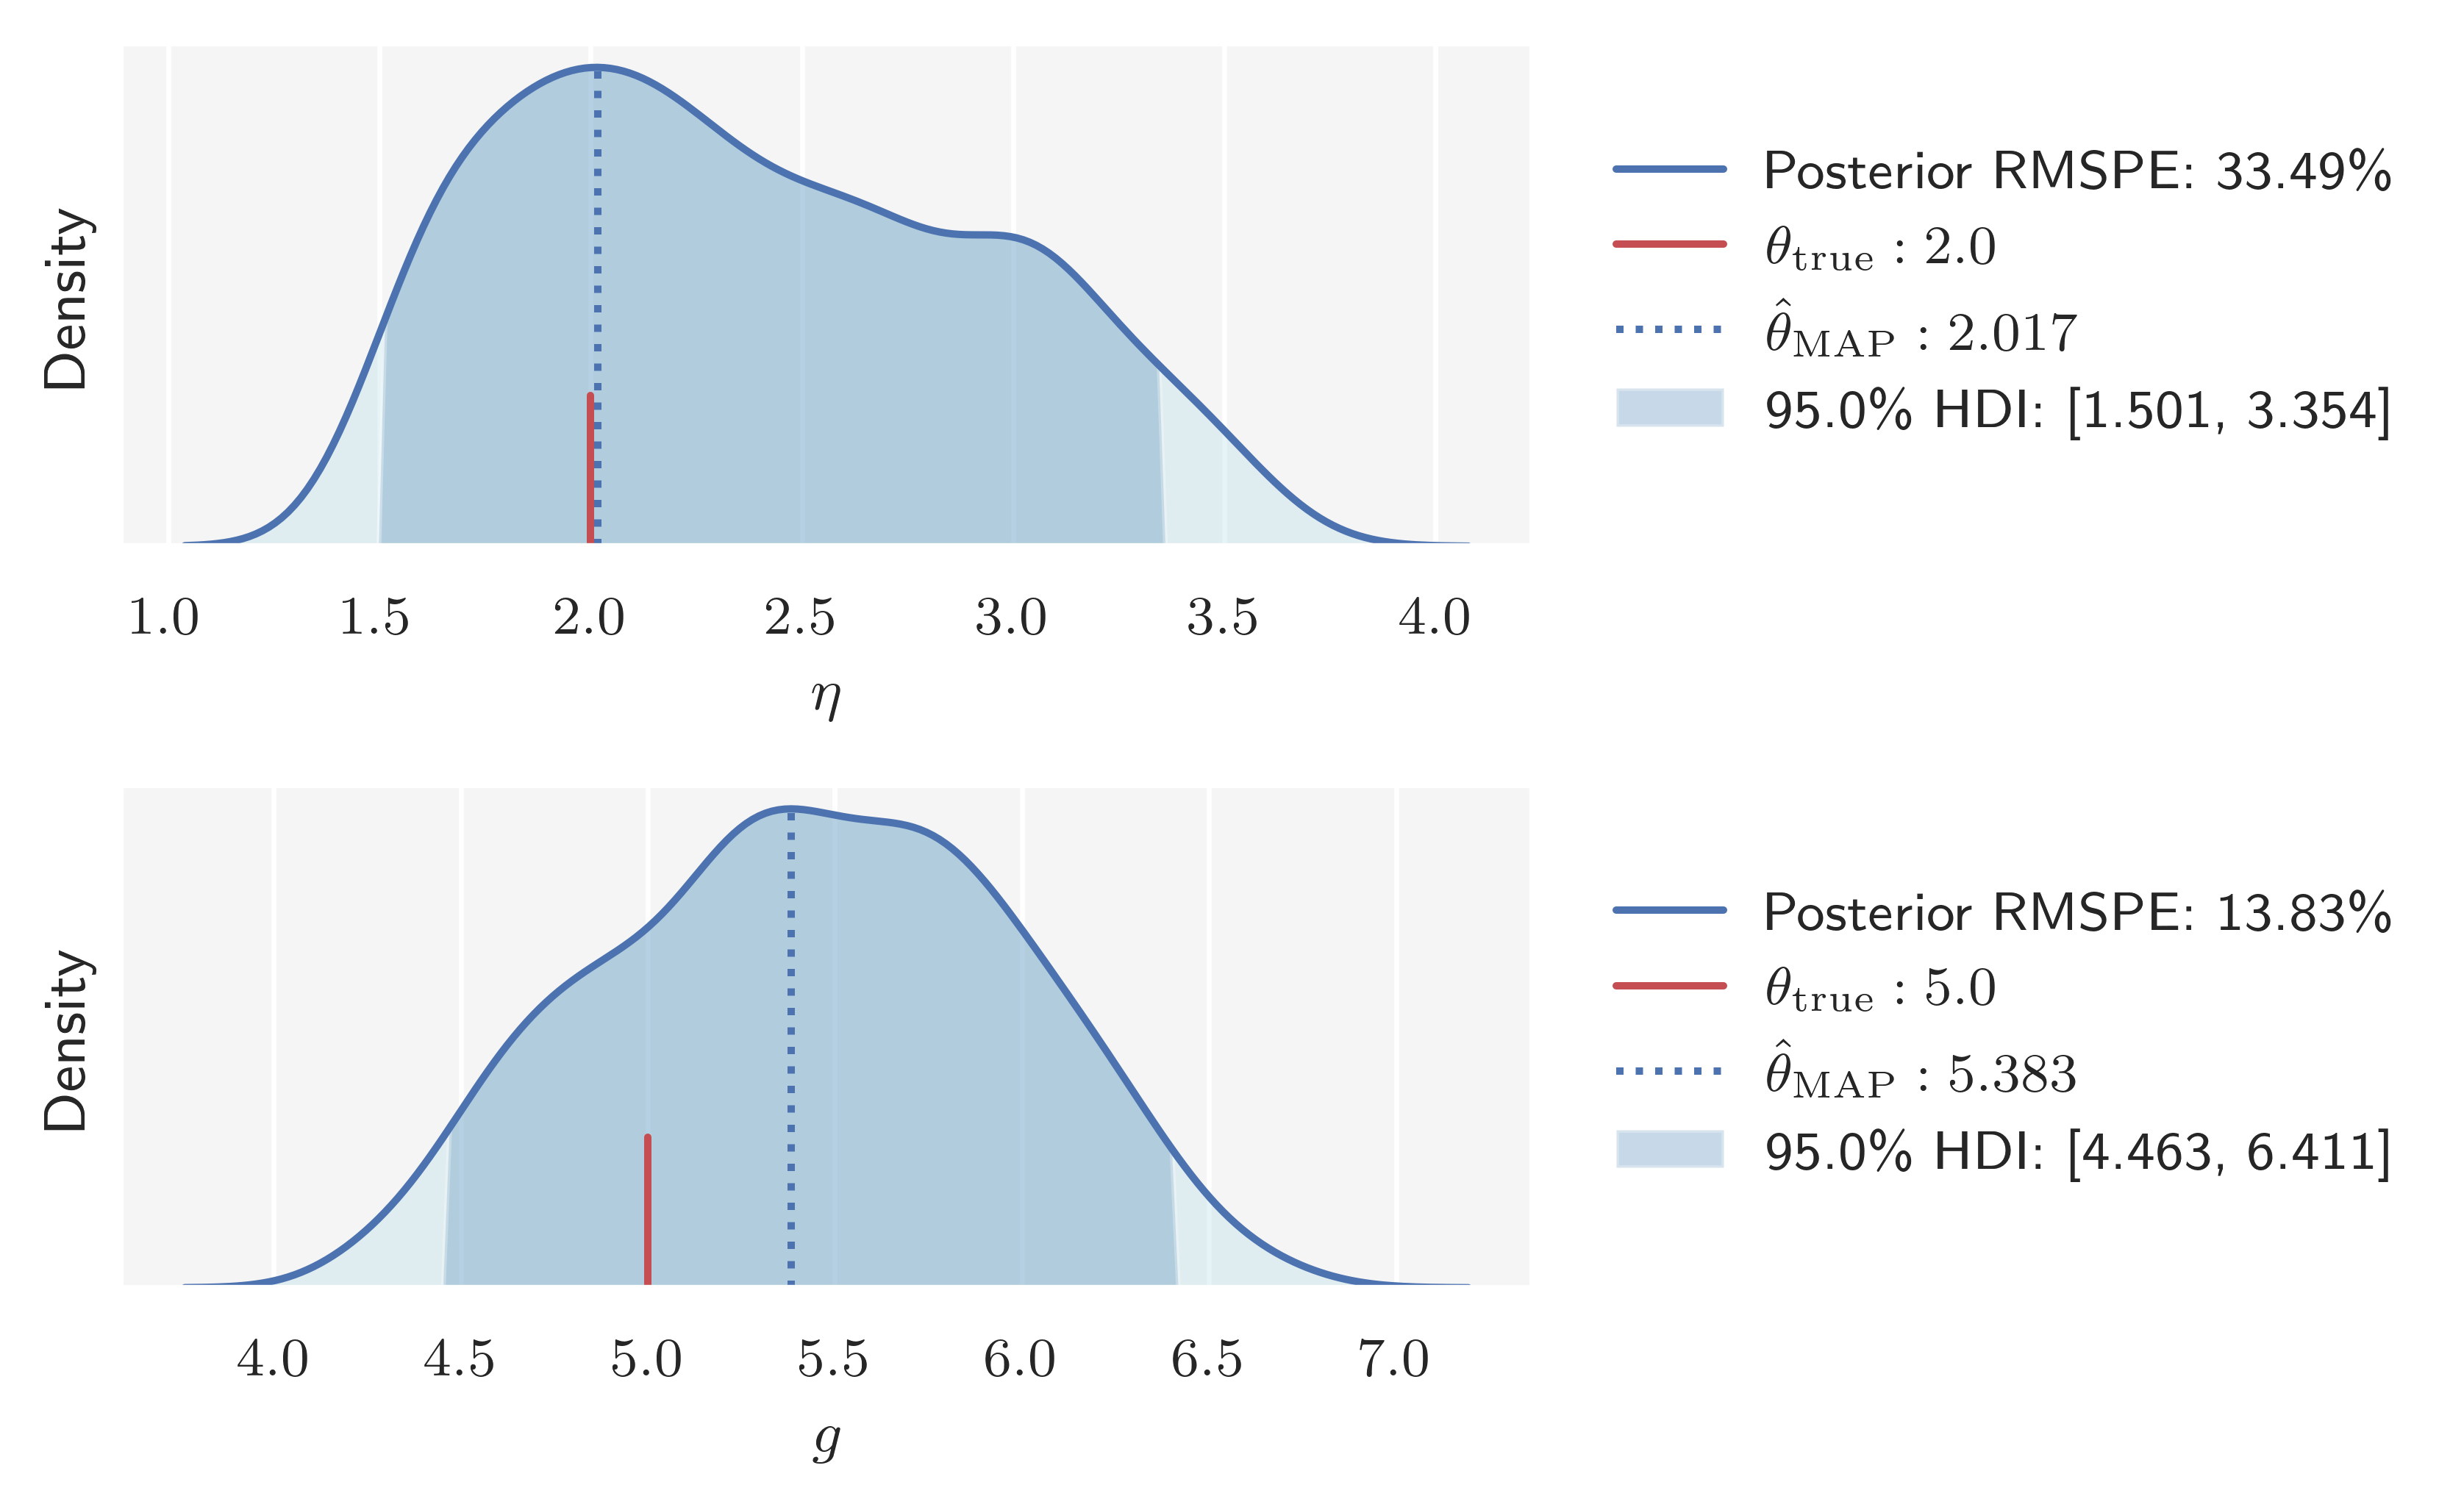

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
plot_posterior(df_org, r'$\eta$', point_estimate='map', theta_true=eta_true, ax=axes[0])
plot_posterior(df_org, r'$g$', point_estimate='map', theta_true=g_true, ax=axes[1])

fig.savefig(fig_path('brunel_posterior_org.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

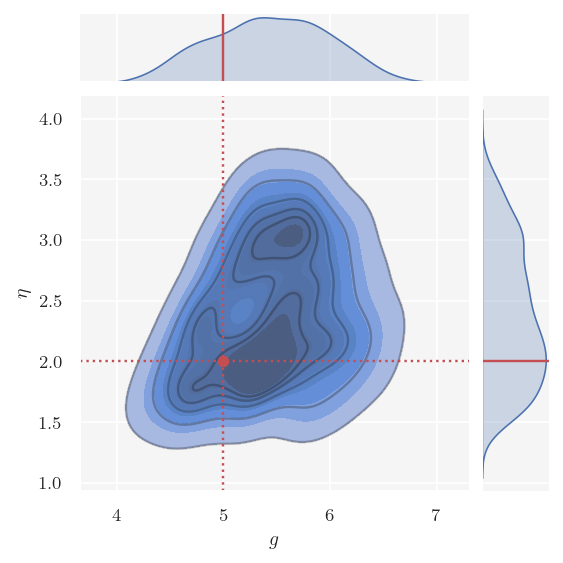

In [35]:
g = plot_joint(df_org, r'$g$', r'$\eta$', g_true, eta_true, height=4)

g.savefig(fig_path('brunel_joint_posterior_org.pdf'), 
          format='pdf', 
          dpi=300, 
          bbox_inches='tight'
         )

### Regression Adjustment

In [36]:
# data (design matrix)
X = copy.deepcopy(sum_stats_accepted)

# scale and apply weights
factor = stat_weights / stat_scale
X *= factor

if X.ndim == 1:
    X = X.reshape(-1, 1)

# augment with column of ones
X = np.c_[np.ones(X.shape[0]), X]

# target
thetas = copy.deepcopy(thetas_accepted)

# transform:
thetas = np.log(thetas)

# smoothing kernel weights
kernel_weights = np.array([epkov_kernel(d, epsilon) for d in dist_accepted])

# Weight matrix
W = np.diag(kernel_weights) 

# compute coefficients (pinv = pseudo-inverse)
#coef = np.linalg.pinv(X.T @ X)  @ X.T @ thetas
coef = np.linalg.pinv(X.T @ (W @ X)) @ X.T @ (W @ thetas)
alpha = coef[0]
beta = coef[1:]

# adjust posterior samples
s_sim_reg = sum_stats_accepted * factor
s_obs_reg = s_obs * factor
correction = (s_sim_reg - s_obs_reg) @ beta

thetas_adjusted = np.exp(np.log(thetas_accepted) - correction)

param_names = [r'$\eta$', r'$g$']
data_reg = dict(zip(param_names, np.stack(thetas_adjusted, axis=-1)))
df_reg = pd.DataFrame.from_dict(data_reg)
df_reg

$\eta$       $g$
0    1.902400  5.122746
1    1.802788  4.835125
2    1.767336  5.046060
3    2.127878  5.187801
4    1.822706  5.046005
..        ...       ...
595  2.122530  5.149357
596  1.996140  5.089948
597  1.939009  4.973030
598  1.773722  4.966575
599  1.713414  5.108254

[600 rows x 2 columns]

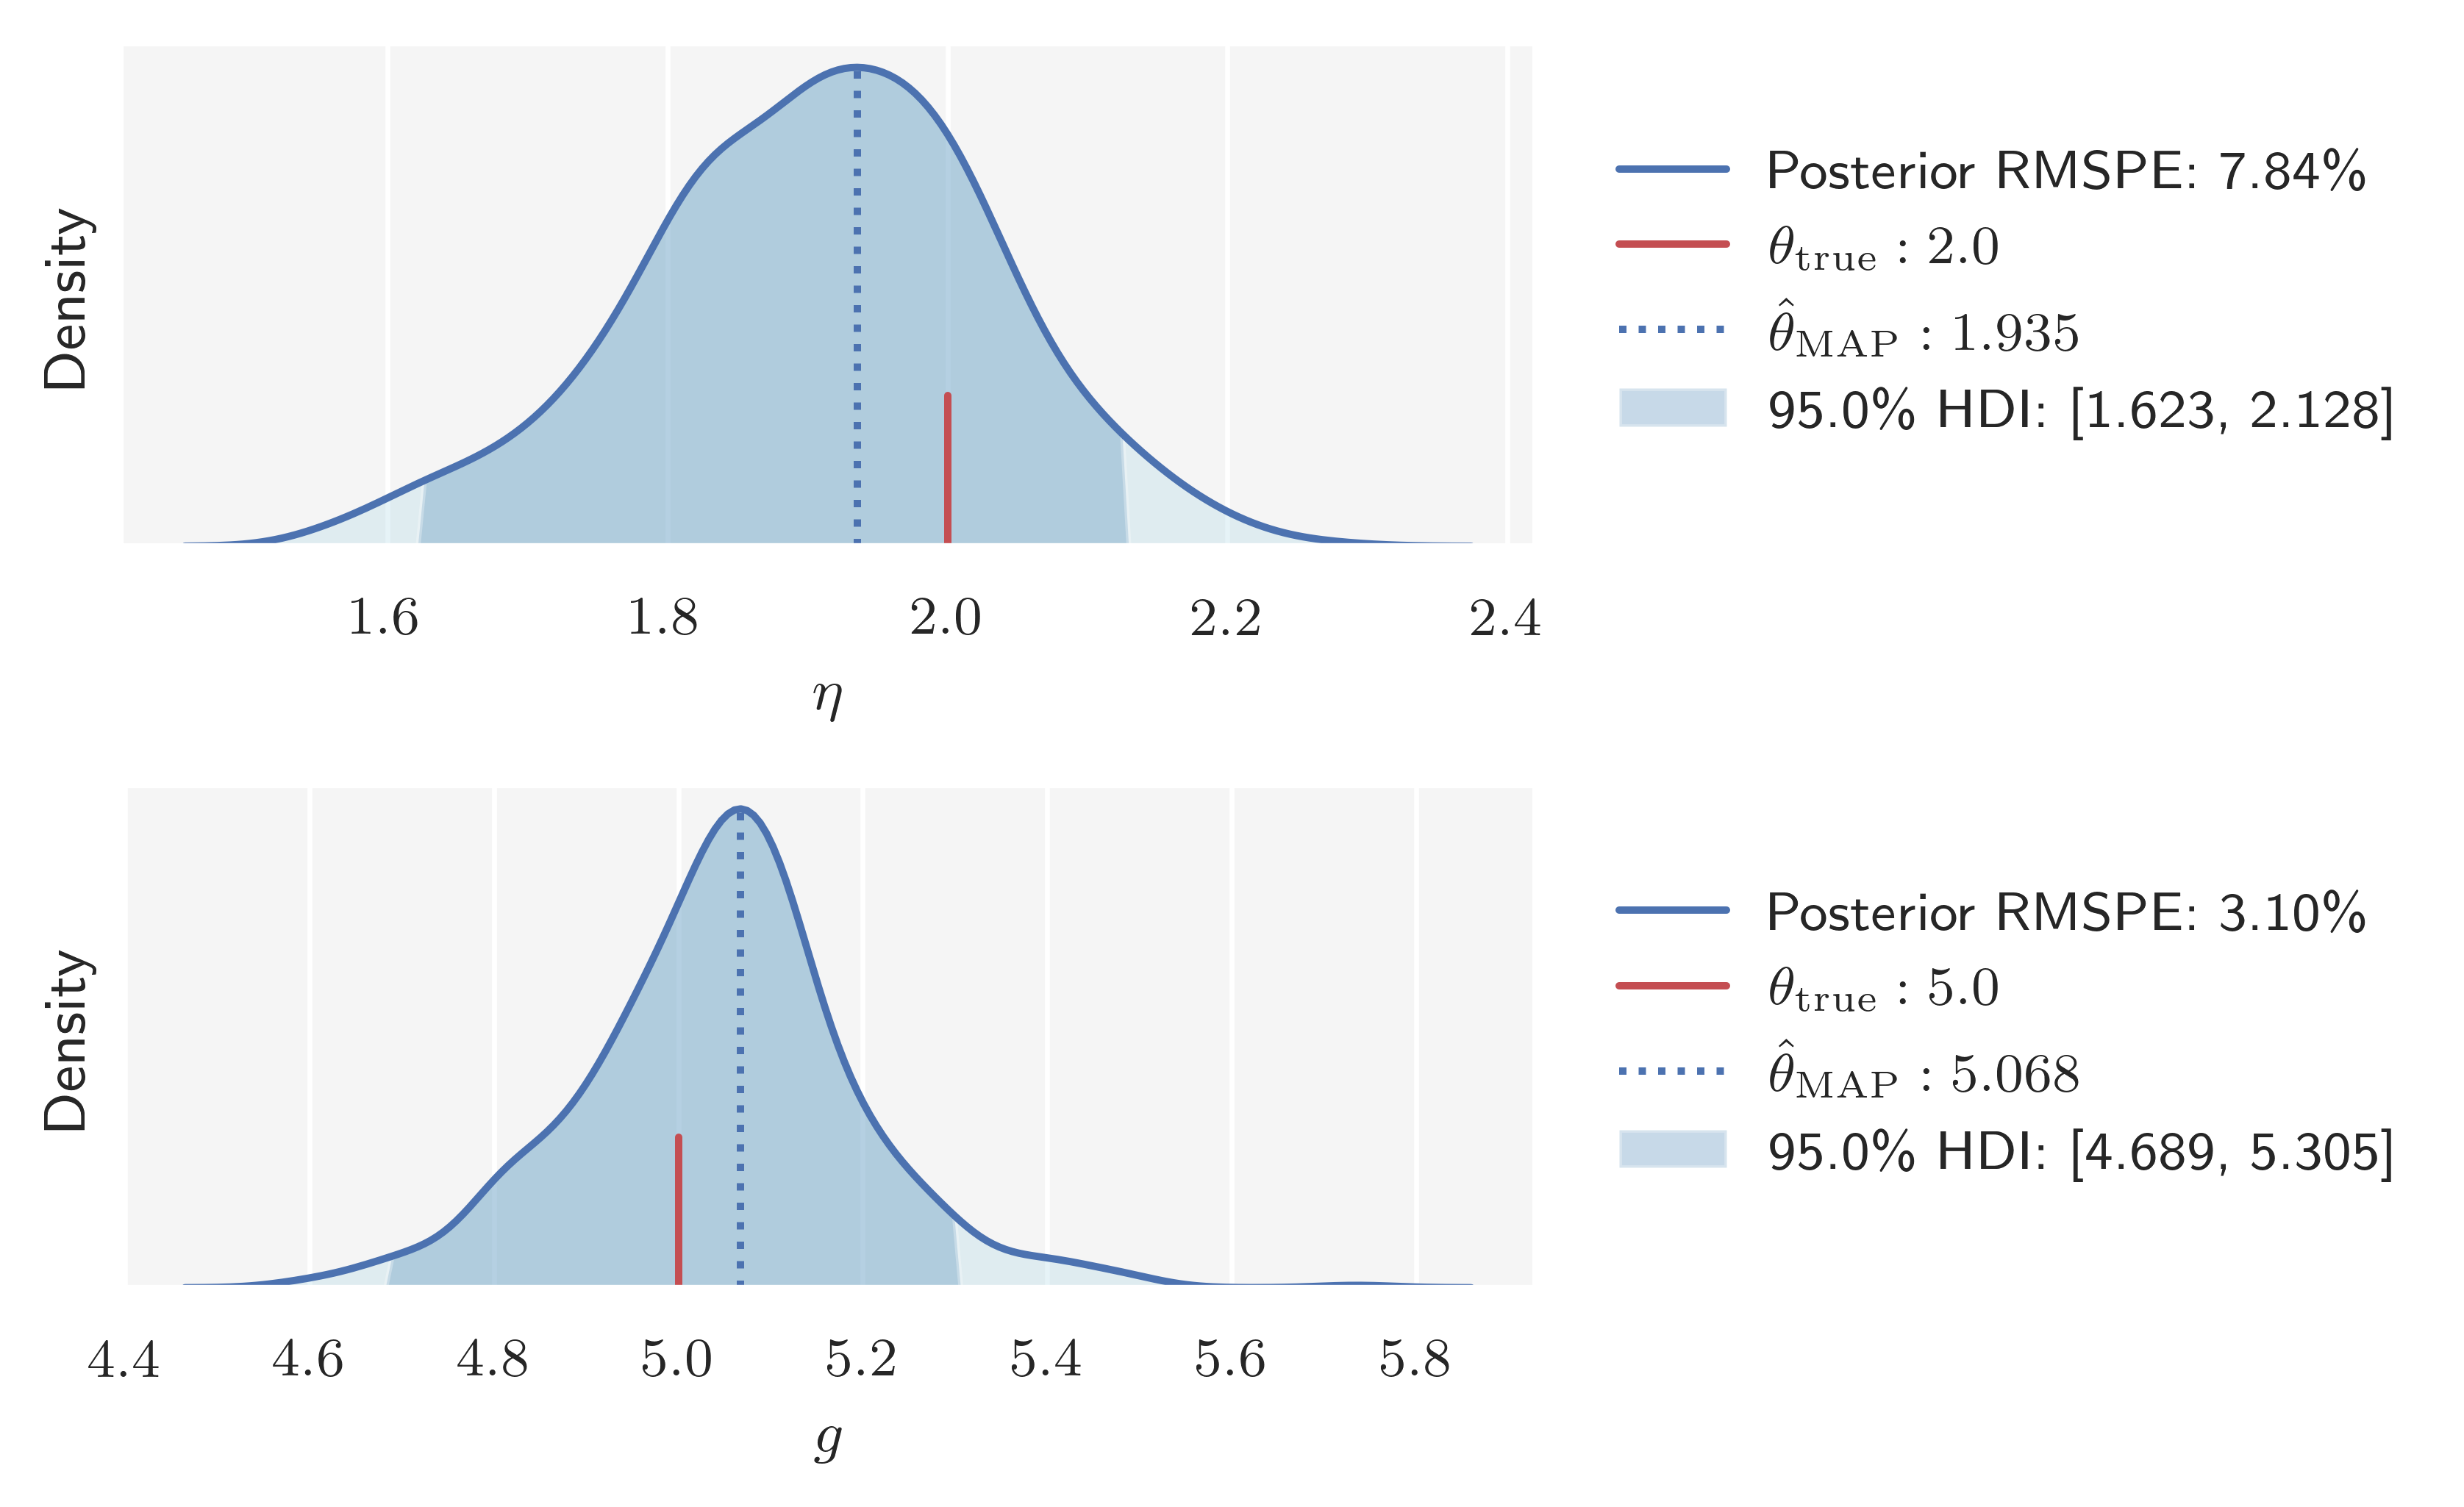

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
plot_posterior(df_reg, r'$\eta$', point_estimate='map', theta_true=eta_true, ax=axes[0])
plot_posterior(df_reg, r'$g$', point_estimate='map', theta_true=g_true, ax=axes[1])

fig.savefig(fig_path('brunel_posterior_reg.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

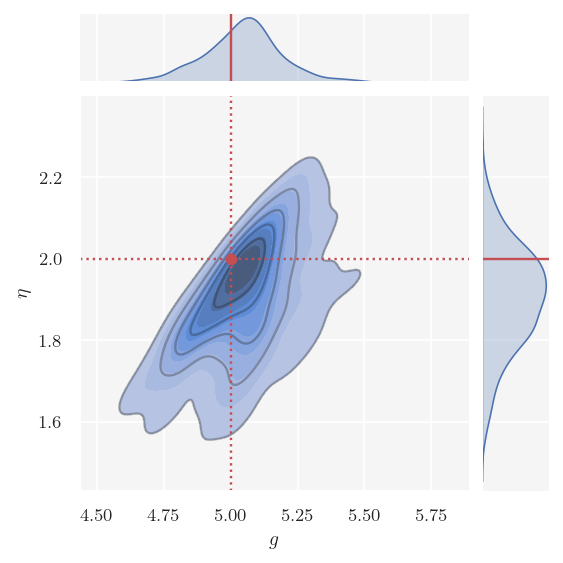

In [38]:
g = plot_joint(df_reg, r'$g$', r'$\eta$', g_true, eta_true, height=4)

g.savefig(fig_path('brunel_joint_posterior_reg.pdf'), 
          format='pdf', 
          dpi=300, 
          bbox_inches='tight'
         )

### Posterior predictive

In [39]:
# simulator
order = 2500    # -> NE=10,000 ; NI=2500 ; N_tot=12,500 ; CE=1000 ; CI=250
epsilon = 0.1   # connection probability
D = 1.5         # synaptic delay (ms)
T = 1000        # simulation time (ms)
N_rec = 20      # record output from N_rec neurons
n_type = 'exc'  # record excitatory spike trains
J = 0.1         # excitatory synapse weight (mV)

# NEST settings
threads = 16        # number of threads to use in simulation
print_time = False  # print simulated time or not

# simulator model
bnet = nm.models.BrunelNet(order=order,
                           epsilon=epsilon,
                           D=D,
                           J=J,
                           T=T,
                           N_rec=N_rec,
                           n_type=n_type,
                           print_time=print_time,
                           threads=threads
                           ) 


# statistics calculator
s_stats = ["mean_firing_rate",  # rate estimation
           "mean_cv",           # spike interval statistic
           "fanofactor"         # statistic across spike trains
           ]

t_start = 100. * pq.ms
t_stop = T * pq.ms

sts = nm.statistics.SpikeTrainStats(stats=s_stats,
                                    t_start=t_start,
                                    t_stop=t_stop
                                    )

### Draw from posterior predictive distribution

In [40]:
# observation

spiketrains_obs = load_spiketrain('data/obs_ai_data.pkl')

sum_stats_obs = sts(spiketrains_obs)

df_obs = pd.DataFrame(np.array([sum_stats_obs]),
                      columns=['Mean firing rate', 'Mean CV', 'Fano factor'])

df_obs.insert(0, r"$\eta$", [2.])
df_obs.insert(1, r"$g$", [5.])
df_obs

$\eta$  $g$  Mean firing rate  Mean CV  Fano factor
0     2.0  5.0          0.036611  0.42506     0.234138

In [41]:
size = 50
idxs = np.random.randint(0, len(df_reg.index), size)
thetas_pred = df_reg.iloc[idxs].to_numpy()
print(thetas_pred)

[[1.95865268 4.99750066]
 [1.87327817 4.94642623]
 [1.79815025 4.8114306 ]
 [1.95126882 5.03047295]
 [1.81495956 4.92629137]
 [2.02867333 5.10829552]
 [1.83954368 4.83422644]
 [1.83768818 4.88202012]
 [1.6651947  4.98620822]
 [1.94191543 5.02634386]
 [1.88860485 4.95416479]
 [1.96112804 4.97816134]
 [1.83042729 5.03728047]
 [1.81694702 5.28121652]
 [2.01434565 5.13072443]
 [2.12512824 5.18946715]
 [1.99333173 5.07697076]
 [1.99869447 5.04368643]
 [1.98351534 5.03789854]
 [1.61974744 5.03274616]
 [1.91264537 4.96275863]
 [1.63493568 5.04184357]
 [1.81762083 4.79026456]
 [1.85422516 5.18765899]
 [1.89954942 4.88218781]
 [1.88528409 4.99194404]
 [1.84108319 4.86497609]
 [1.69158274 4.6676314 ]
 [2.16887883 5.21329685]
 [1.9876041  5.01309972]
 [1.62662216 4.88638702]
 [2.01049495 5.08655093]
 [2.02338398 5.07050414]
 [2.05498539 5.11194301]
 [1.77057128 4.93383432]
 [1.80014364 5.01276616]
 [1.91895136 4.92775602]
 [1.85675793 4.95981026]
 [1.93883544 5.11938668]
 [1.74345041 4.78364862]


In [42]:
s_stats_pred = []
corr_pred = []

for thetas_ in thetas_pred:
    spiketrains_pred = bnet(*thetas_)
    s_stats_pred_i = sts(spiketrains_pred)
    s_stats_pred.append(s_stats_pred_i)
    #mean_frate_pred.append(sum_stats_pred[0])
    #mean_cv_pred.append(sum_stats_pred[1])
    #fanofactor_pred.append(sum_stats_pred[2])
    
    binned_spiketrains_pred = BinnedSpikeTrain(spiketrains_pred, bin_size=10 * pq.ms)
    corrcoef_matrix_pred = correlation_coefficient(binned_spiketrains_pred)
    corr_pred.append(corrcoef_matrix_pred)

/Users/nicolai/opt/anaconda3/envs/master/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 1 last spike(s) of the input spiketrain


In [43]:
data_pred = dict(zip(s_stats, np.stack(s_stats_pred, axis=-1)))
df_pred = pd.DataFrame.from_dict(data_pred)
df_pred.insert(0, r"$\eta$", thetas_pred[:, 0])
df_pred.insert(1, r"$g$", thetas_pred[:, 1])

df_pred.rename(columns={"mean_firing_rate": "Mean firing rate",
                   "mean_cv": "Mean CV",
                   "fanofactor": "Fano factor"
                  },
          inplace=True
         )

df_pred

$\eta$       $g$  Mean firing rate   Mean CV  Fano factor
0   1.958653  4.997501          0.036222  0.427888     0.179289
1   1.873278  4.946426          0.034722  0.420935     0.278613
2   1.798150  4.811431          0.037056  0.388124     0.105495
3   1.951269  5.030473          0.035944  0.427308     0.208989
4   1.814960  4.926291          0.034444  0.397571     0.185207
5   2.028673  5.108296          0.036278  0.433978     0.197165
6   1.839544  4.834226          0.037167  0.403517     0.147429
7   1.837688  4.882020          0.035556  0.430989     0.155618
8   1.665195  4.986208          0.027667  0.467578     0.297080
9   1.941915  5.026344          0.035111  0.427763     0.304649
10  1.888605  4.954165          0.036056  0.429356     0.143137
11  1.961128  4.978161          0.036778  0.422233     0.121196
12  1.830427  5.037280          0.032222  0.434998     0.142151
13  1.816947  5.281217          0.026722  0.487442     0.326415
14  2.014346  5.130724          0.034500  0.458850     0.230786
15  2.125128  5.189467          0.035722  0.446251     0.226224
16  1.993332  5.076971          0.035944  0.444098     0.219444
17  1.998694  5.043686          0.036667  0.411820     0.262088
18  1.983515  5.037899          0.036333  0.447033     0.258659
19  1.619747  5.032746          0.025833  0.447518     0.123786
20  1.912645  4.962759          0.035778  0.405371     0.191515
21  1.634936  5.041844          0.025889  0.438631     0.407396
22  1.817621  4.790265          0.037889  0.395017     0.156764
23  1.854225  5.187659          0.028278  0.458162     0.223843
24  1.899549  4.882188          0.037111  0.408188     0.269863
25  1.885284  4.991944          0.033667  0.421286     0.293976
26  1.841083  4.864976          0.036444  0.405637     0.133333
27  1.691583  4.667631          0.036944  0.376696     0.132432
28  2.168879  5.213297          0.037500  0.420406     0.188184
29  1.987604  5.013100          0.037056  0.413950     0.139237
30  1.626622  4.886387          0.028889  0.421215     0.146690
31  2.010495  5.086551          0.035556  0.446465     0.141573
32  2.023384  5.070504          0.036167  0.429746     0.198252
33  2.054985  5.111943          0.036222  0.438134     0.177008
34  1.770571  4.933834          0.032167  0.426767     0.195238
35  1.800144  5.012766          0.031611  0.432076     0.197436
36  1.918951  4.927756          0.037333  0.410754     0.037838
37  1.856758  4.959810          0.034056  0.400699     0.160340
38  1.938835  5.119387          0.033167  0.444643     0.205136
39  1.743450  4.783649          0.035167  0.362726     0.105714
40  1.750230  4.826842          0.034778  0.405398     0.095322
41  1.879663  5.184780          0.030056  0.455288     0.174370
42  1.861184  5.075171          0.031556  0.422594     0.157325
43  1.810359  5.263593          0.027389  0.489091     0.127922
44  1.928098  5.051850          0.034000  0.406131     0.177193
45  1.913283  4.962993          0.035444  0.417945     0.130114
46  2.040786  5.179196          0.034056  0.438580     0.201744
47  1.925966  4.966349          0.035889  0.392611     0.095897
48  1.823890  4.977776          0.033333  0.436882     0.257927
49  1.917604  5.119775          0.032111  0.467171     0.166460

In [44]:
eta_mean = np.mean(thetas_pred[:, 0])
g_mean = np.mean(thetas_pred[:, 1])
s_stats_mean = np.mean(np.array(s_stats_pred), axis=0)
df_pred_mean = pd.DataFrame(np.array([s_stats_mean]),
                      columns=['Mean firing rate', 'Mean CV', 'Fano factor'])

df_pred_mean.insert(0, r"$\eta$", [eta_mean])
df_pred_mean.insert(1, r"$g$", [g_mean])

df_pred_mean

$\eta$       $g$  Mean firing rate  Mean CV  Fano factor
0  1.884597  5.008562          0.034049  0.42687     0.187989

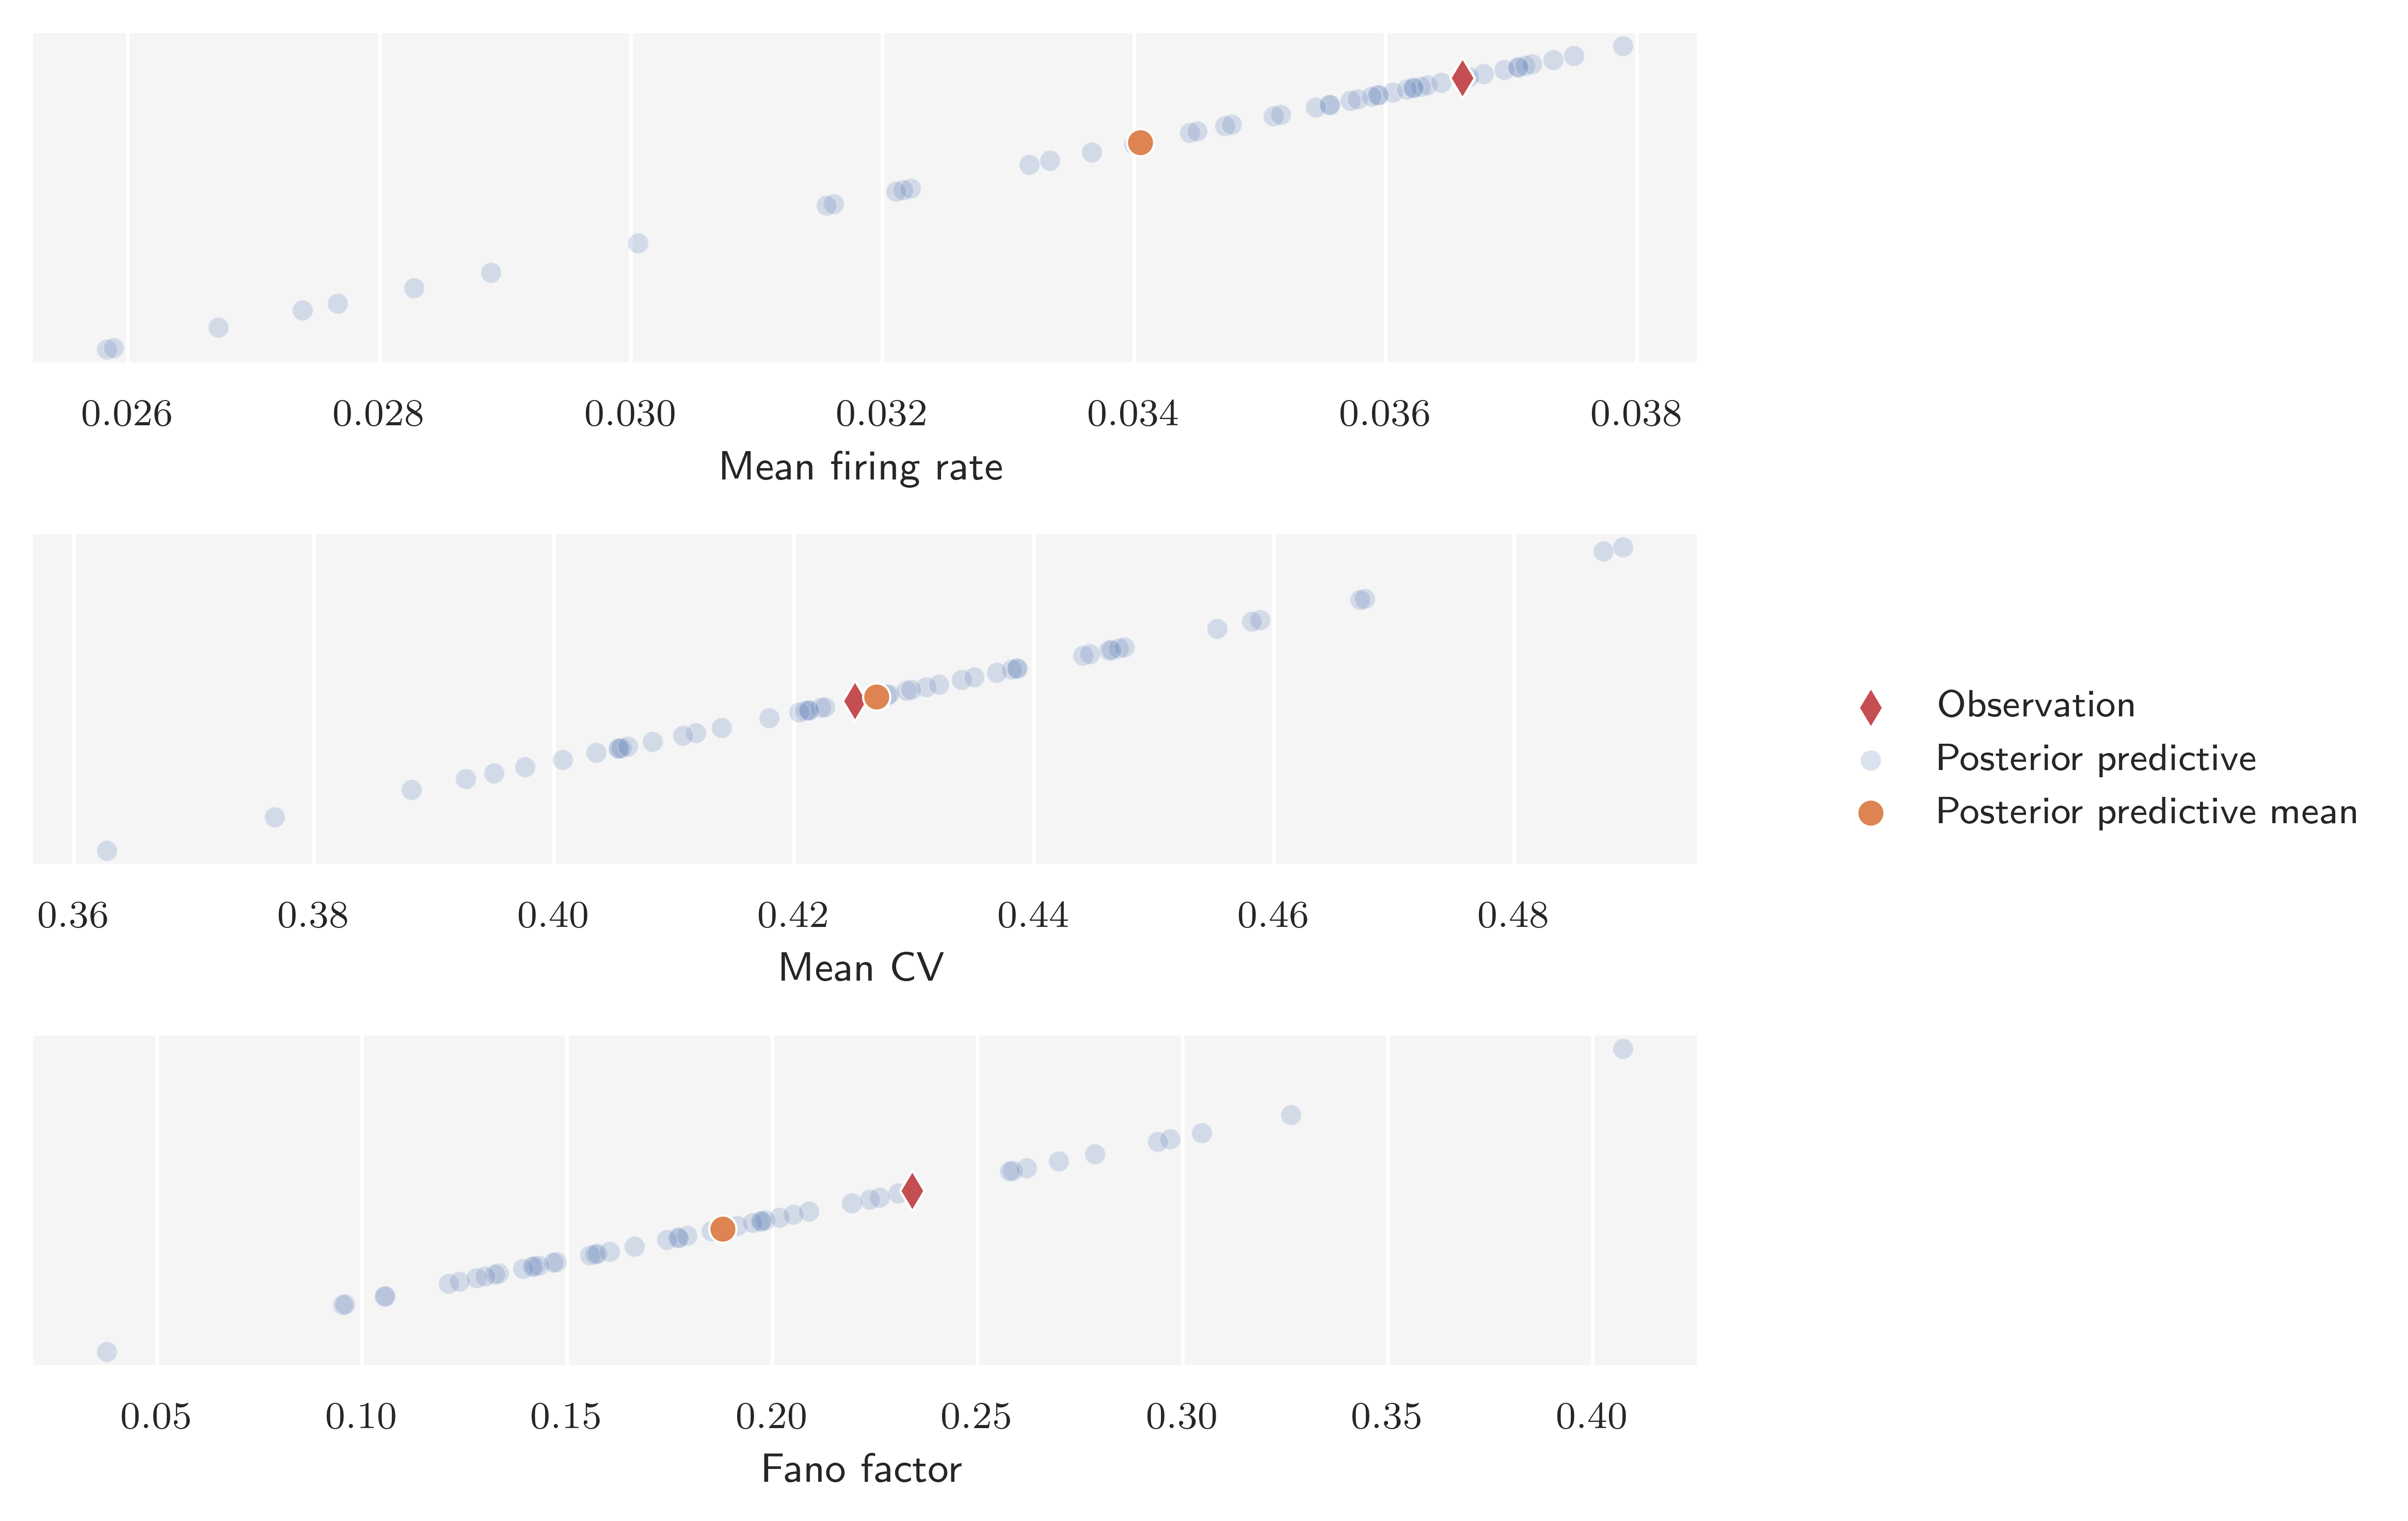

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(fs[0], 5), tight_layout=True, dpi=300)

# Mean firing rate
ax = axes[0]

sns.scatterplot(data=df_obs, 
                x="Mean firing rate", 
                y="Mean firing rate", 
                color='r',
                marker='d',
                s=45,
                label='Observation',
                ax=ax,
                zorder=2
               )

sns.scatterplot(data=df_pred, 
                x="Mean firing rate", 
                y="Mean firing rate", 
                color='C0',
                alpha=0.2,
                #s='d',
                label='Posterior predictive',
                ax=ax,
                zorder=1
               )

sns.scatterplot(data=df_pred_mean, 
                x="Mean firing rate", 
                y="Mean firing rate", 
                color='C1',
                s=40,
                label='Posterior predictive mean',
                ax=ax,
                zorder=3
               )

ax.set(yticks=[],
       ylabel='')

# Mean CV
ax2 = axes[1]

sns.scatterplot(data=df_obs, 
                x="Mean CV", 
                y="Mean CV", 
                color='r',
                marker='d',
                s=45,
                ax=ax2,
                zorder=2
               )

sns.scatterplot(data=df_pred, 
                x="Mean CV", 
                y="Mean CV", 
                color='C0',
                alpha=0.2,
                ax=ax2,
                zorder=1
               )

sns.scatterplot(data=df_pred_mean, 
                x="Mean CV", 
                y="Mean CV", 
                color='C1',
                s=40,
                ax=ax2,
                zorder=3
               )

ax2.set(yticks=[],
        ylabel='')

# Fano factor
ax3 = axes[2]

sns.scatterplot(data=df_obs, 
                x="Fano factor", 
                y="Fano factor", 
                color='r',
                marker='d',
                s=45,
                ax=ax3,
                zorder=2
               )

sns.scatterplot(data=df_pred, 
                x="Fano factor", 
                y="Fano factor", 
                color='C0',
                alpha=0.2,
                ax=ax3,
                zorder=1
               )

sns.scatterplot(data=df_pred_mean, 
                x="Fano factor", 
                y="Fano factor", 
                color='C1',
                s=40,
                ax=ax3,
                zorder=3
               )

ax3.set(yticks=[],
        ylabel='')

# legend

handles, labels = ax.get_legend_handles_labels()

fig.legend(
    handles,
    labels,
    loc='center left',
    bbox_to_anchor=(1.04, 0.5),
    fancybox=True,
    borderaxespad=0.1,
    ncol=1,
    frameon=False
)

ax.legend([], [], frameon=False)

fig.savefig(fig_path('brunel_post_pred.pdf'), 
                format='pdf', 
                dpi=300, 
                bbox_inches='tight'
               )

In [46]:
corr_pred = np.array(corr_pred)
corr_pred_mean = np.mean(corr_pred, axis=0)
corr_pred_std = np.std(corr_pred, axis=0)

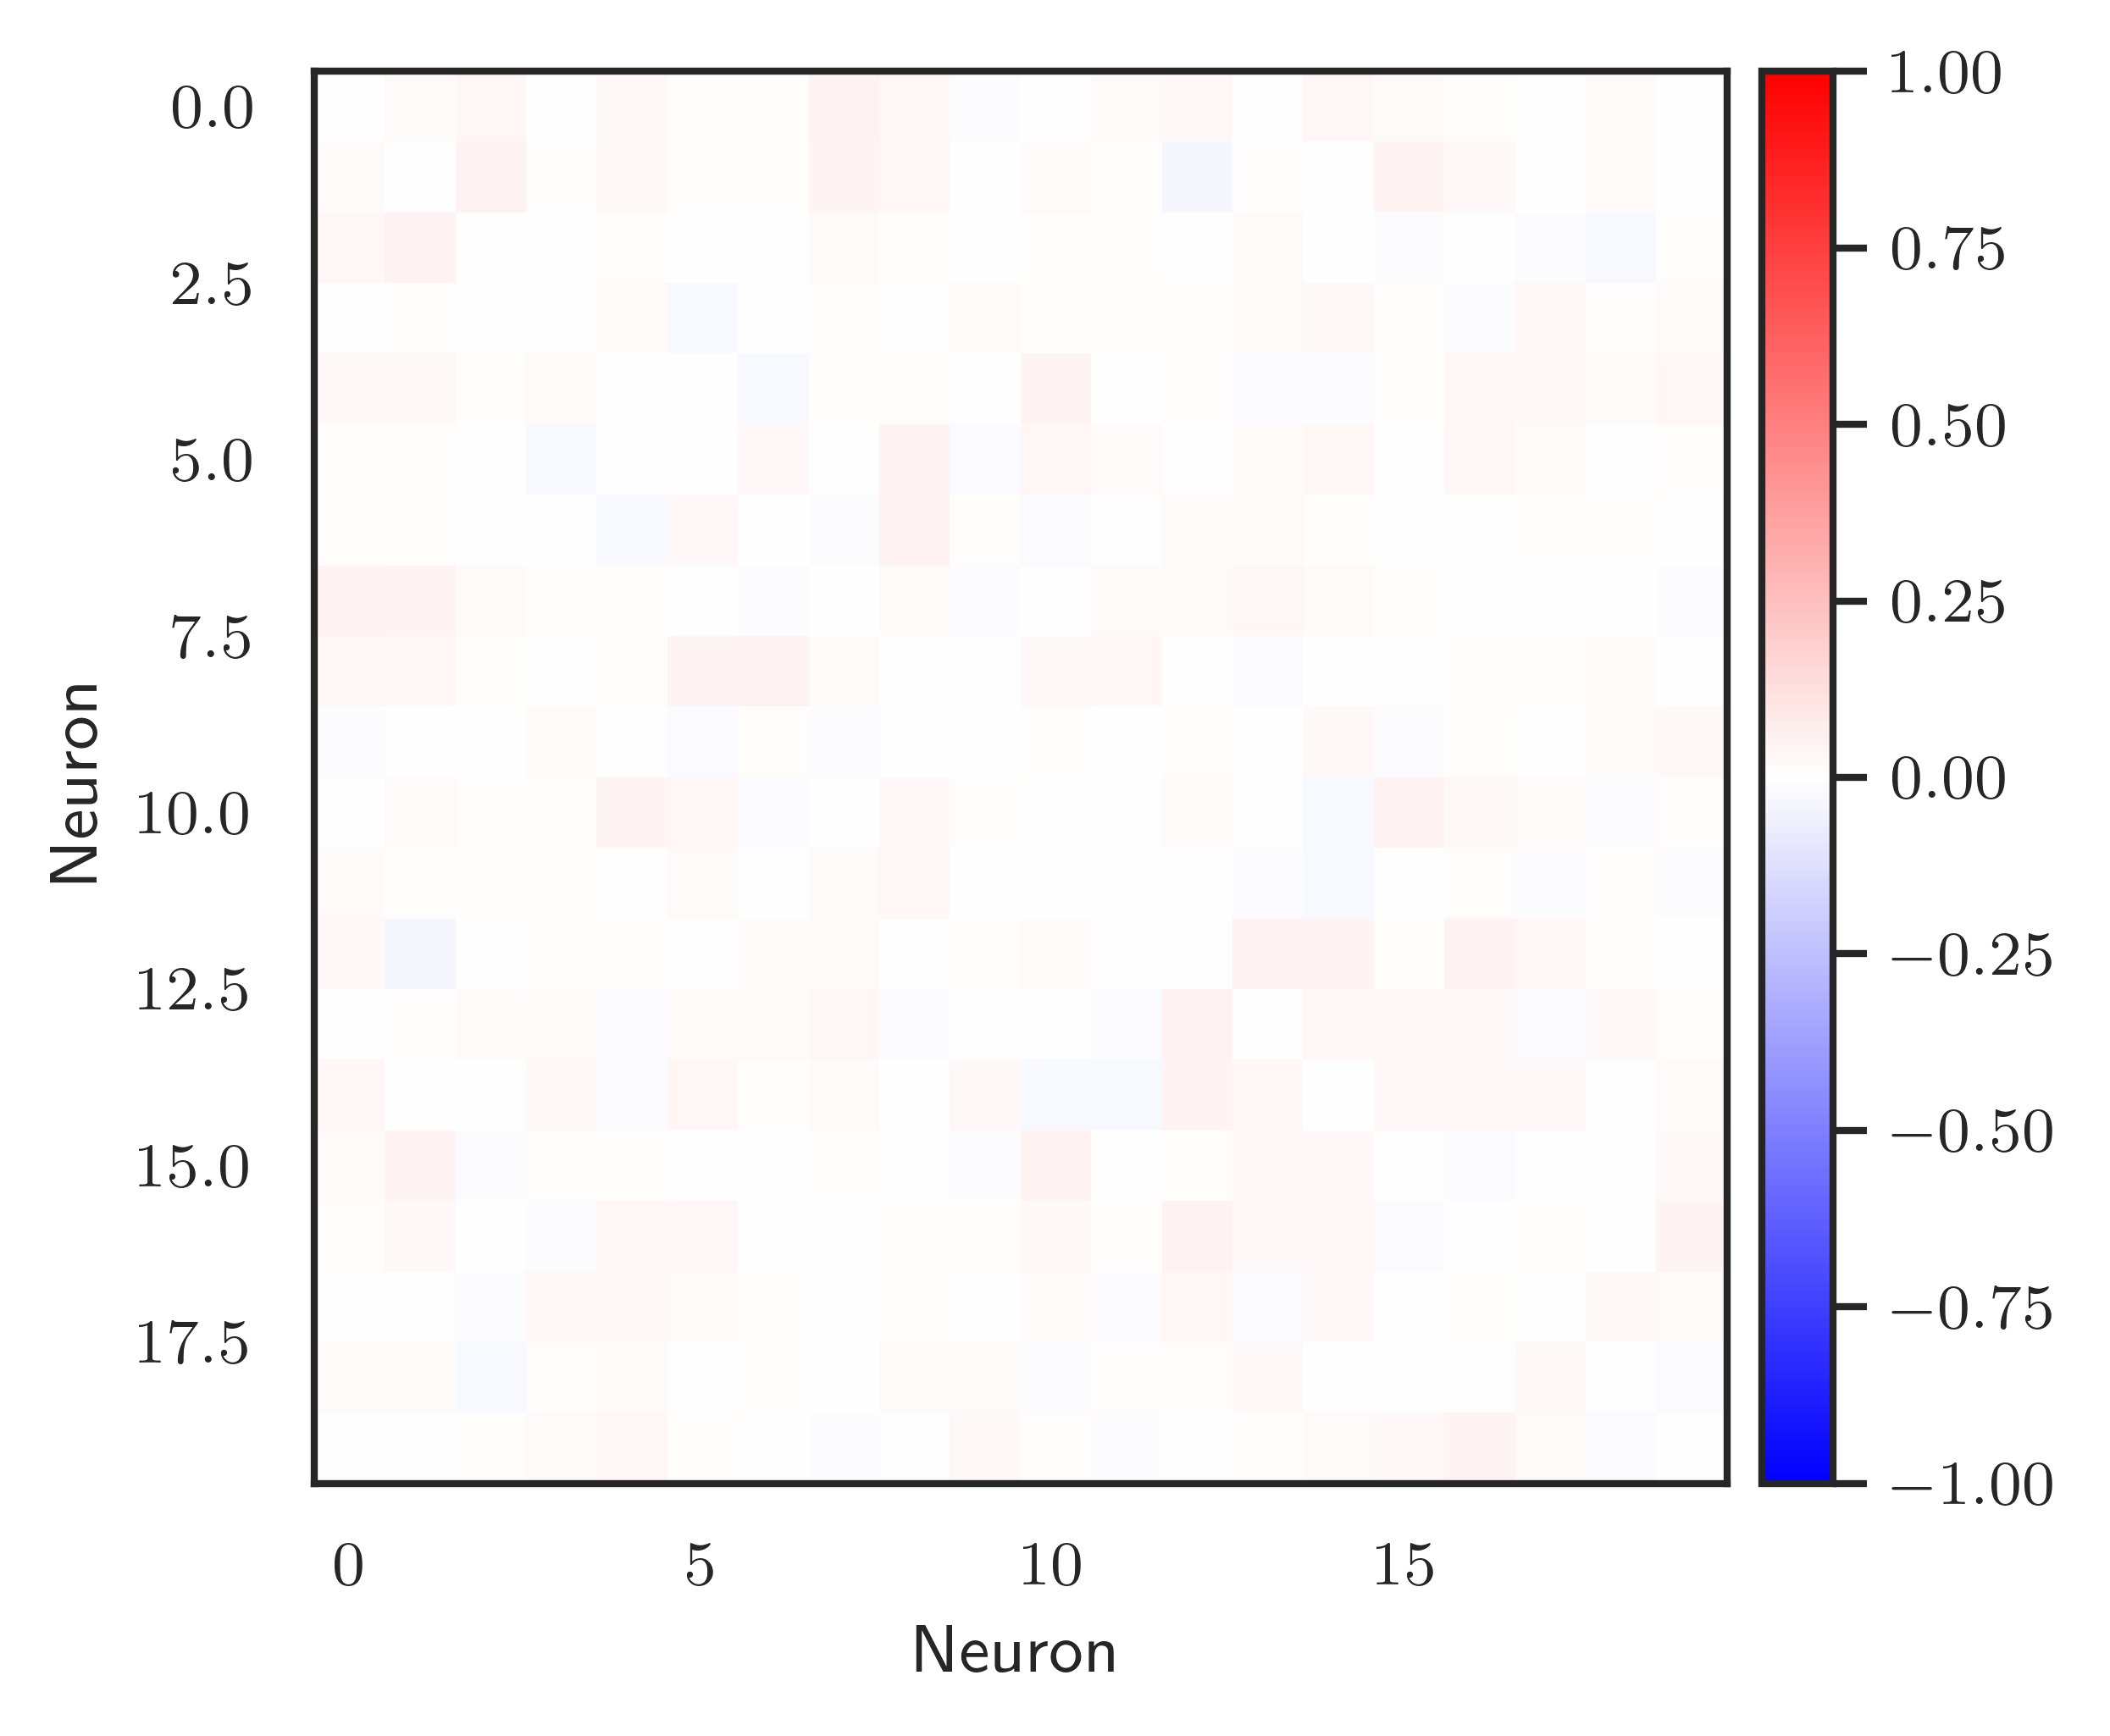

In [47]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

    plot_corrcoef(corr_pred_mean, colormap='bwr', correlation_range='full', axes=ax)

    ax.set(xlabel='Neuron',
           ylabel='Neuron',
           #title='Correlation coefficient matrix'
           )

    fig.savefig(fig_path('brunel_pred_corr.pdf'), 
                format='pdf', 
                dpi=300, 
                bbox_inches='tight'
               )

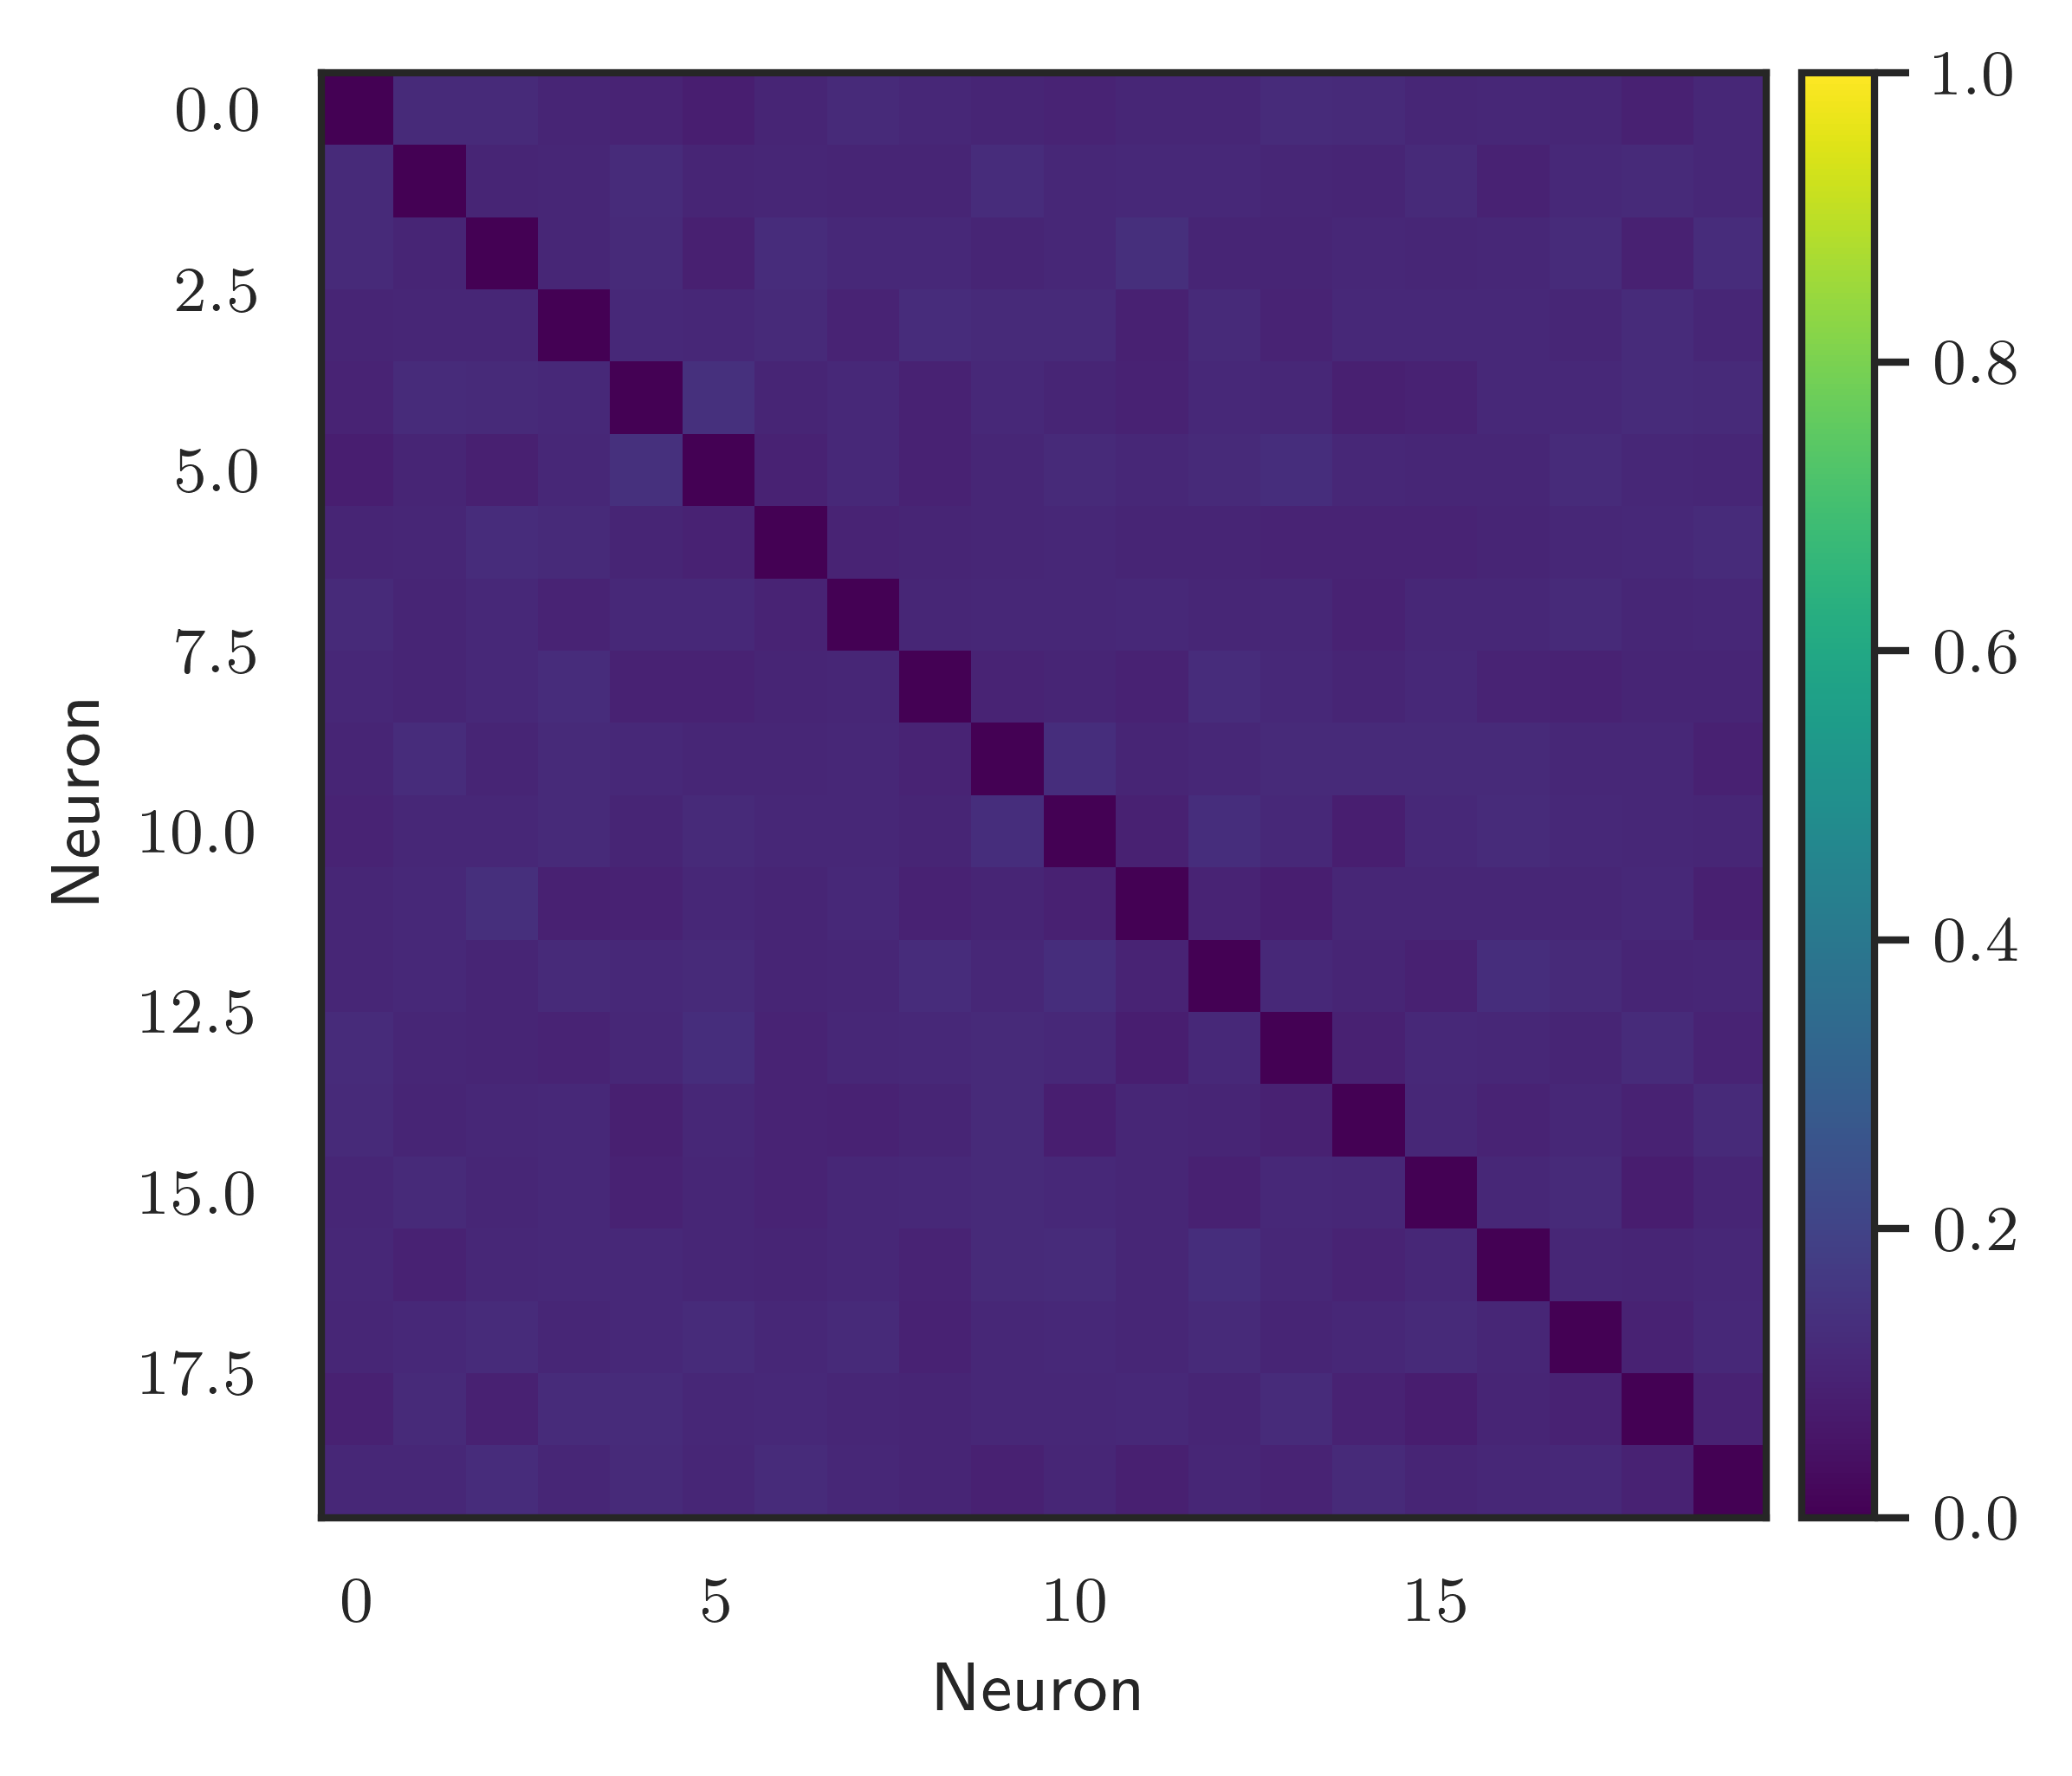

In [48]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

    plot_corrcoef(corr_pred_std, colormap='viridis', correlation_range=(0., 1.), axes=ax)

    ax.set(xlabel='Neuron',
           ylabel='Neuron',
           #title='Correlation coefficient matrix'
           )

     
    fig.savefig(fig_path('brunel_pred_corr_std.pdf'), 
                format='pdf', 
                dpi=300, 
                bbox_inches='tight'
               )